# Pythonで学ぶ画像認識　第6章 画像キャプショニング
## 第6.5節 Transformerによる画像キャプショニングを実装してみよう

### ライブラリの準備

###モジュールのインポートとGoogleドライブのマウント

In [1]:
import os
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
from tqdm.notebook import tqdm
import pickle
import random
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
import skimage.transform
from collections import deque

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dataset

from timm.scheduler import CosineLRScheduler

# 認識エラー率を計算するモジュールをインポート
import levenshtein

#from google.colab import drive
#drive.mount('/content/drive')

import sys
sys.path.append('6_5_transformer_captioning')

import util
import model

In [2]:
word_to_id_file = '../../6_img_captioning/model/best/word_to_id3_train2017.pkl'
id_to_word_file = '../../6_img_captioning/model/best/id_to_word3_train2017.pkl'

# 辞書（単語→単語ID）の読み込み
with open(word_to_id_file, 'rb') as f:
    word_to_id = pickle.load(f)
word_to_id['<mask>'] = 0
    
# 辞書（単語ID→単語）の読み込み
with open(id_to_word_file, 'rb') as f:
    id_to_word = pickle.load(f)
id_to_word[0] = '<mask>'

print( word_to_id['<mask>'] )
print( word_to_id['<null>'] )

0
13581


### 位置エンコーディングの実装

In [6]:
class PositionalEncoding(nn.Module):
    '''
    位置エンコーディング （Positional encoding）
    dim_embedding: 埋込み次元
    dropout      : ドロップアウト確率
    max_len      : 入力の最大系列長
    temperature  : 温度定数
    '''
    def __init__(self, dim_embedding: int, dropout: float=0.1,
                 max_len: int=5000, temperature=10000):
        super().__init__()

        assert dim_embedding % 2 == 0

        self.dropout = nn.Dropout(p=dropout)

        dim_t = torch.arange(0, dim_embedding, 2)
        dim_t = dim_t / dim_embedding
        dim_t = temperature ** dim_t

        x_encoding = torch.arange(max_len).unsqueeze(1)
        x_encoding = x_encoding / dim_t

        # 位置情報を保持するテンソル
        pe = torch.zeros(max_len, dim_embedding)
        pe[:, ::2] = x_encoding.sin()
        pe[:, 1::2] = x_encoding.cos()

        # PEをメモリに保存
        self.register_buffer('pe', pe)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        x = x + self.pe[:seq]
        x = self.dropout(x)

        return x

### Transformerデコーダの実装

In [7]:
class TransformerDecoderLayer(nn.Module):
    '''
    Transformerデコーダ層
    dim_hidden     : 特徴量次元
    num_heads      : アテンションヘッドの数
    dim_feedforward: FNNの中間特徴量次元
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_hidden: int, num_heads: int,
                 dim_feedforward: int=2048, dropout: int=0.1):
        super().__init__()

        # 単語ベクトルに対するマルチヘッド自己アテンション
        self.self_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(dim_hidden)
        self.dropout1 = nn.Dropout(dropout)

        # エンコーダとデコーダ中間出力に対するマルチヘッドアテンション
        self.cross_attention = nn.MultiheadAttention(
            dim_hidden, num_heads, dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim_hidden)
        self.dropout2 = nn.Dropout(dropout)

        # FNN＆レイヤー正規化
        self.fnn = nn.Sequential(
            nn.Linear(dim_hidden, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, dim_hidden)
        )
        self.norm3 = nn.LayerNorm(dim_hidden)
        self.dropout3 = nn.Dropout(dropout)

    '''
    Transformerデコーダ層の順伝播
    tgt     : デコーダへの入力系列,
              [バッチサイズ, 系列長, 埋め込み次元]
    memory  : エンコーダ層の特徴量, [バッチサイズ, 1, 埋め込み次元]
    tgt_mask: 入力系列のマスク, [系列長, 系列長]
    '''
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor,
                tgt_mask: torch.Tensor=None):

        # デコーダ入力に対するマスク付きマルチヘッド自己アテンション
        tgt2 = self.self_attention(
            query=tgt, key=tgt, value=tgt, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout1(tgt2)  # 残差接続
        tgt = self.norm1(tgt)            # レイヤー正規化

        # エンコーダとデコーダ中間出力に対するマルチヘッド交差アテンション
        tgt2 = self.cross_attention(
            query=tgt, key=memory, value=memory)[0]
        tgt = tgt + self.dropout2(tgt2)  # 残差接続
        tgt = self.norm2(tgt)            # レイヤー正規化

        # FNN&レイヤー正規化
        tgt2 = self.fnn(tgt)
        tgt = tgt + self.dropout3(tgt2)  # 残差接続
        tgt = self.norm3(tgt)            # レイヤー正規化

        return tgt

### CaptioningTransformerの実装

In [8]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, dim_embedding: int, dim_feedforward: int,
                 num_heads: int, num_layers: int, vocab_size: int,
                 null_index: int, word_to_id: list, dropout: float=0.5, 
                 iter_max: int=10):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(
            vocab_size, dim_embedding, padding_idx=null_index)

        # 位置エンコーディング
        self.positional_encoding = PositionalEncoding(dim_embedding)

        # Transformerデコーダ
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(
                dim_embedding, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # 単語出力分布計算
        self.linear = nn.Linear(dim_embedding, vocab_size)

        # パラメータ初期化
        self._reset_parameters()
        
        # lengths_predictor の全結合
        self.length_linear = nn.Linear( dim_embedding, 1 )
        
        self.word_to_id = word_to_id
        self.iter_max = iter_max

    '''
    パラメータの初期化関数
    '''
    def _reset_parameters(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, nn.LayerNorm):
                nn.init.zeros_(module.bias)
                nn.init.ones_(module.weight)

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, features: torch.Tensor,
                captions: torch.Tensor, lengths: float, is_inference = False ):
        seq = captions.shape[1]

        if is_inference == False:
            lengths = self.lengths_predictor( features )
        else:
            lengths = lengths
        
        
        # 単語埋め込み [バッチサイズ, 系列長]
        # -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)

        # 位置エンコーディング
        embeddings = self.positional_encoding(embeddings)

        features = features.unsqueeze(1)

        # 未来のキャプションを参照しないようにマスク行列を生成
        #tgt_mask = torch.tril(features.new_ones((seq, seq)))
        #tgt_mask = tgt_mask == 0

        # Transformerデコーダでキャプション生成
        # 画像の特徴も入力する
        for layer in self.decoder_layers:
            #embeddings = layer(embeddings, features, tgt_mask)
            embeddings = layer(embeddings, features, tgt_mask=None)
            
        # [バッチサイズ, 系列長, 埋め込み次元]
        # -> [バッチサイズ, 系列長, 辞書の次元]
        preds = self.linear(embeddings)
        
        #print( "argmax of preds[0]:", torch.argmax( preds[0], dim = 1 ) )

        return preds, lengths
    
    def lengths_predictor(self, features):
        
        x = self.length_linear( features )
        lengths = torch.squeeze( x, dim = 1 )
        
        return lengths

    '''
    CaptioningTransformerのサンプリング処理
    features  : 画像特徴ベクトル [バッチサイズ, 埋め込み次元]
    word_to_id: 単語->単語ID辞書
    max_length: 最大キャプション長
    '''
    @torch.no_grad()
    def sample(self, features: torch.Tensor, word_to_id: list,
               max_length: int=30):
        bs = features.shape[0]

        # <start> トークンで出力キャプションを初期化
        captions = features.new_full(
            (bs, 1), word_to_id['<start>'], dtype=torch.int64)

        # 単語を逐次予測
        for _ in range(max_length):
            preds = self.forward(features, captions)
            preds = preds[:, -1]
            preds = preds.softmax(dim=1)
            words = preds.argmax(dim=1, keepdim=True)

            captions = torch.cat((captions, words), dim=1)

        return captions

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 512   # 埋め込み層の次元
        self.dim_feedforward = 2048 # FNNの中間特徴量次元
        self.num_heads = 8         # マルチヘッドアテンションのヘッド数
        self.num_layers = 12        # Transformerデコーダ層の層数
        #self.lr = 0.001            # 学習率
        self.lr = 0.005            # 学習率
        self.dropout = 0.3         # dropout確率
        self.batch_size = 200       # ミニバッチ数
        self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨

        # パスの設定
        #self.img_directory = 'val2014'
        self.img_directory = '../6_5_myoriginal_transformer_captioning/train2017'
        #self.anno_file = 'drive/MyDrive/python_image_recognition/data/coco2014/captions_val2014.json'
        #self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/word_to_id.pkl'
        #self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model'
        #self.anno_file = '../../data/coco2014/captions_val2014.json'
        self.anno_file = '../../data/coco2014/captions_train2017.json'
        #self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id2.pkl'
        #self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word2.pkl'
        self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id3_train2017.pkl'
        self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word3_train2017.pkl'
        self.save_directory = '../../6_img_captioning/model'

        # 検証に使う学習セット内のデータの割合
        #self.val_ratio = 0.3
        self.val_ratio = 0.1

        # データローダーに使うCPUプロセスの数
        self.num_workers = 4
        #self.num_workers = 0

        # 学習に使うデバイス
        self.device = 'cuda'
        #self.device = 'cpu'

        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

### 学習率スケジューラ

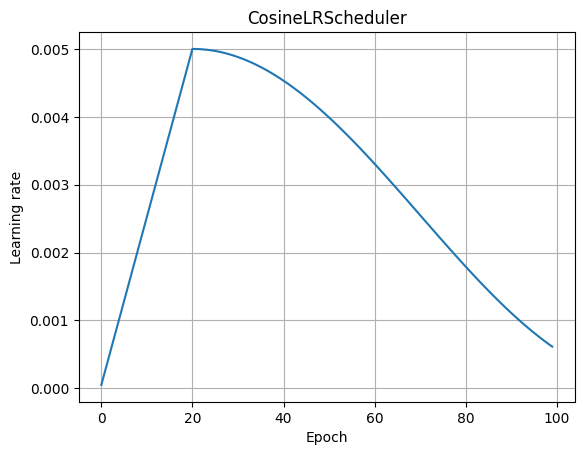

In [7]:
linear = torch.nn.Linear(1, 1)
optimizer = torch.optim.AdamW(linear.parameters(), lr = 5e-3)
scheduler = CosineLRScheduler(
    optimizer, t_initial=100, lr_min=1e-4, warmup_t=20,
    warmup_lr_init=5e-5, warmup_prefix=True)

lrs = []
for i in range(100):
    #lrs.append(scheduler.get_epoch_values(i))
    lrs.append(scheduler._get_values(i))
plt.plot(lrs)
plt.title("CosineLRScheduler")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.grid()

In [8]:
def time_masking(dec_input: torch.Tensor, dec_input_lens: torch.Tensor, mask_id: int) -> tuple[torch.Tensor, torch.BoolTensor]:
    """
    Args:
        hidden_states (torch.Tensor): with shape `(B, L, D)`
        lengths (torch.Tensor): with shape `(B)`

    Returns:
        tuple(
        Masked hidden states (torch.Tensor with shape `(B, L, D)`),
        Time mask (torch.BoolTensor with `(B, L)`)
        )
    """
       
    mask = torch.zeros_like( dec_input, device=dec_input.device, dtype=bool )       
        
    for n in range( dec_input.size(0) ):
        m_max = torch.randint( low = 0, high = dec_input_lens[n], size=(1, ) )
        m = torch.randint( low = 0, high = dec_input_lens[n], size=(m_max,) )
        dec_input[n,m] = mask_id
        mask[n,m] = True
        
    return dec_input, mask


### 学習を行う関数

In [9]:
def train():
    config = ConfigTrain()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)
    word_to_id['<mask>'] = 0
    
    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)
    id_to_word[0] = '<mask>'

    # 辞書サイズを保存
    vocab_size = len(word_to_id)

    # モデル出力用のディレクトリを作成
    os.makedirs(config.save_directory, exist_ok=True)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # COCOデータロードの定義
    train_dataset = dataset.CocoCaptions(root=config.img_directory,
                                         annFile=config.anno_file,
                                         transform=transforms)

    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    collate_func_lambda = lambda x: util.collate_func(x, word_to_id)
    train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=config.batch_size,
                        num_workers=config.num_workers,
                        sampler=train_sampler,
                        #sampler=val_set,
                        collate_fn=collate_func_lambda)
    val_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=config.batch_size,
                        num_workers=config.num_workers,
                        sampler=val_set,
                        collate_fn=collate_func_lambda)

    # モデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'],  word_to_id, config.dropout)
    encoder.to(config.device)
    decoder.to(config.device)

    # 損失関数の定義
    loss_func = lambda x, y: F.cross_entropy(
        x, y, ignore_index=word_to_id.get('<null>', None))

    # 最適化手法の定義
    params = list(decoder.parameters()) + \
    list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=config.lr)

    # WarmupとCosine Decayを行うスケジューラを利用
    scheduler = CosineLRScheduler(
        optimizer, t_initial=config.num_epochs, lr_min=1e-4,
        warmup_t=20, warmup_lr_init=5e-5, warmup_prefix=True)

    # 学習経過の書き込み
    now = datetime.datetime.now()
    train_loss_file = '{}/6-68_train_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
    val_loss_file = '{}/6-68_val_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

    # 学習
    val_loss_best = float('inf')
    for epoch in range(config.num_epochs):
        #scheduler.step(epoch)
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 学習モードに設定
            encoder.train()
            decoder.train()

            train_losses = deque()
            train_errors = deque()
            n_batch = 0
            for imgs, captions, caption_lengths in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)
                caption_lengths = torch.tensor(caption_lengths).to(config.device)

                optimizer.zero_grad()

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                #captions_in = captions[:, :-1]
                masked_captions, mask = time_masking( captions.clone(), caption_lengths,  word_to_id['<mask>'] )
                #outputs = decoder(features, captions_in)
                outputs, lengths = decoder(features, masked_captions, caption_lengths)
                hypo_ids = torch.argmax( outputs, dim = 2 )
                
                # 損失の計算
                # <start>の予測は行わないため除外
                #targets = captions[:, 1:]
                #if n_batch % 300 == 299:
                    #print( "argmax outputs[0]:", hypo_ids[0] )
                    #print( "captions[0]:", targets[0])
                    #if torch.any( captions[0] == 0 ):
                    #    print( "captions[0] includes 0.")
                    #print( "captions[0]:", captions[0])
                # 単語軸が第1軸である必要があるため、転置
                #outputs = outputs.transpose(1, 2)
                #loss = loss_func(outputs, targets)
                loss0 = loss_func(outputs[mask], captions[mask])
                loss1 = nn.MSELoss()( lengths, caption_lengths.to( torch.float32 ) )
                loss = loss0 + loss1
                
                # 誤差逆伝播
                loss.backward()

                optimizer.step()

                n = 0
                hypo_sentence = []
                ref_sentence = []
                #for hypo_id, caption in zip( hypo_ids, captions ):
                total_error = 0
                total_token_length = 0
                for (hypo_id, caption) in zip( hypo_ids, captions ):
                    #hypo = ctc_simple_decode( hypo_id.to(device=config.device), id_to_word )                
                    hypo = []
                    #print( "len hypo_id:", len( hypo_id ))
                    for m in hypo_id:
                        hypo.append(id_to_word[m.item()])
                        #print( "m:", m )
                        if id_to_word[m.item()] == '<end>':
                            break

                    #print( "hypo:", hypo )
                    # 正解の文字列を取得
                    reference = []
                    for m in caption:
                        reference.append(id_to_word[m.item()])
                        if id_to_word[m.item()] == '<end>':
                            break

                        
                    # 認識誤りを計算
                    (error, substitute, 
                     delete, insert, ref_length) = \
                        levenshtein.calculate_error(hypo,
                                                    reference)
                    #print( ' '.join(hypo) )
                    #print( '\n')
                    #print( ' '.join(reference ) )
                    #print( '\n')
                    
                    #print( "error:", error )
                    # 誤り文字数を累積する
                    total_error += error
                    # 文字の総数を累積する
                    total_token_length += ref_length

                    if n < 4 and n_batch == len( train_loader ) -1 :
                        hypo_sentence.append( ' '.join(hypo) )
                        ref_sentence.append( ' '.join(reference ) )
                    
                    n += 1
                
                n_batch += 1
                avg_error = total_error / total_token_length * 100
                #print( "avg_error:", avg_error )
                
                # 学習時の損失をログに書き込み
                train_losses.append(loss.item())
                train_errors.append( avg_error )
                if len(train_losses) > config.moving_avg:
                    train_losses.popleft()
                    train_errors.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(train_losses).mean().item(),
                    'WER': torch.Tensor(train_errors).mean().item()
                })
                with open(train_loss_file, 'a') as f:
                    print(f'{epoch}, {loss0.item()}, {loss1.item()}, {loss.item()}, {avg_error}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )


        # 学習率を表示
        print(f'学習率: {scheduler._get_values(epoch)}')

        # 検証
        with tqdm(val_loader) as pbar:
            pbar.set_description(f'[検証]')

            # 評価モード
            encoder.eval()
            decoder.eval()

            val_losses = deque()
            val_errors = deque()
            n_batch = 0
            #for imgs, captions, _ in pbar:
            for imgs, captions, caption_lengths in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)
                caption_lengths = torch.tensor(caption_lengths).to(config.device)

                with torch.no_grad():                
                    # エンコーダ-デコーダモデル
                    features = encoder(imgs)
                    # 最後の単語から次を予測する必要はないため最後の単語を除外
                    #captions_in = captions[:, :-1]
                    masked_captions, mask = time_masking( captions.clone(), caption_lengths,  word_to_id['<mask>'] )
                    #outputs = decoder(features, captions_in)
                    outputs, lengths = decoder(features, masked_captions, caption_lengths)
                    hypo_ids = torch.argmax( outputs, dim = 2 )

                # 損失の計算
                # <start>の予測は行わないため除外
                #targets = captions[:, 1:]
                # 単語軸が第1軸である必要があるため、転置
                #outputs = outputs.transpose(1, 2)
                #loss = loss_func(outputs, targets)
                loss0 = loss_func(outputs[mask], captions[mask])
                loss1 = nn.MSELoss()( lengths, caption_lengths.to( torch.float32 ) )
                loss = loss0 + loss1
                val_losses.append(loss.item())

                #if n_batch % 50 == 49:
                #    print( "argmax outputs[0]:", hypo_ids[0] )
                #    #print( "captions[0]:", targets[0])
                #    print( "captions[0]:", captions[0])                         
                    
                n = 0
                hypo_sentence = []
                ref_sentence = []
                total_error = 0
                total_token_length = 0
                for (hypo_id, caption) in zip( hypo_ids, captions ):
                    #hypo = ctc_simple_decode( hypo_id.to(device=config.device), id_to_word )      
                    hypo = []
                    for m in hypo_id:
                        hypo.append(id_to_word[m.item()])
                        if id_to_word[m.item()] == '<end>':
                            break
                    # 正解の文字列を取得
                    reference = []
                    for m in caption:
                        reference.append(id_to_word[m.item()])
                        if id_to_word[m.item()] == '<end>':
                            break
                        
                    # 認識誤りを計算
                    (error, substitute, 
                     delete, insert, ref_length) = \
                        levenshtein.calculate_error(hypo,
                                                    reference)
                    
                    # 誤り文字数を累積する
                    total_error += error
                    # 文字の総数を累積する
                    total_token_length += ref_length


                    if n < 4 and n_batch == len( val_loader ) -1 :
                        hypo_sentence.append( ' '.join(hypo) )
                        ref_sentence.append( ' '.join(reference ) )
                    
                    n += 1
                
                n_batch += 1
                avg_error = total_error / total_token_length * 100                    

                val_losses.append(loss.item())
                val_errors.append(avg_error)
                
                if len(val_losses) > config.moving_avg:
                    val_losses.popleft()
                    val_errors.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(val_losses).mean().item(),
                    'WER': torch.Tensor(val_errors).mean().item()
                })                
                
                # Validation Lossをログに書き込み
                with open(val_loss_file, 'a') as f:
                    print(f'{epoch}, {loss0.item()}, {loss1.item()}, {loss.item()},  {avg_error}', file=f)
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
        # Loss 表示
        val_loss = np.mean(val_losses)
        print(f'Validation loss: {val_loss}')
        print(f'Validation WER: {avg_error}')

        # より良い検証結果が得られた場合、モデルを保存
        if val_loss < val_loss_best:
            val_loss_best = val_loss

            # エンコーダモデルを保存
            torch.save(
                {'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                f'{config.save_directory}/6-68_encoder_best.pth')
            
            # デコーダモデルを保存
            torch.save(
                {'epoch': epoch,
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
                f'{config.save_directory}/6-68_decoder_best.pth')

            
        # エンコーダモデルを保存
        torch.save(
                {'epoch': epoch,
                'encoder_state_dict': encoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
            f'{config.save_directory}/6-68_encoder_curr.pth')
            
        # デコーダモデルを保存
        torch.save(
                {'epoch': epoch,
                'decoder_state_dict': decoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,},
            f'{config.save_directory}/6-68_decoder_curr.pth')         

###学習データの解凍

###学習の実行

In [10]:
train()

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a <unk> youngster dressed in a baby blue sweater is wearing a catcher's mitt in his left hand <end>
hypo: <start> a man a a a a a a a a a a a <end>
refe: <start> two teddy bears in a display case with four other teddy bears staged in the background <end>
hypo: <start> a man of a a a a a a a a <end>
refe: <start> one woman leaps to hit a tennis ball while her teammate guards the net <end>
hypo: <start> a man of a a a a a a a <end>
refe: <start> a snowboarder is grabbing his board in midair near a rockstar energy drink sign <end>
hypo: <start> a man of a a a a a a a a <end>
学習率: [5e-05]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man of a a a a a a a a a <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a man of a a a a a a a a a <end>
refe: <start> little boys playing with a skate board on a dirt road <end>
hypo: <start> a man man a a a a a a a a <end>
refe: <start> a group of people sitting around a lake with small animals <end>
hypo: <start> a man of a a a a a a a a <end>
Validation loss: 19.733373763344506
Validation WER: 68.80733944954129


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> young girl in pink spaghetti string tank top squinting as she bites off the end of a piece of pizza <end>
hypo: <start> a man with a a a a a a a a a a a a and a a <end>
refe: <start> a couple of businessmen walk passed a group of pedestrians with umbrellas on the wet sidewalk of a city street <end>
hypo: <start> a man of a a a a a a a a a a a a a <end>
refe: <start> conference room with big screen on wall and table in the center with a workstation on the side <end>
hypo: <start> a living with a a a a and a a a a a a a and <end>
refe: <start> a male standing on a board inthe water hanging by one arm to a rope line <end>
hypo: <start> a man of a a a a a a the a a the the <end>
学習率: [0.0002975]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a cat cat a a a a a a a a a a a a a
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a living with a a a a a a a a a a a a <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> a pizza of a a a a a a a a a a a it <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a street of a a a a a a a a a street <end>
Validation loss: 14.961064512079412
Validation WER: 67.73255813953489


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> back view of a female tennis player on a clay court who has just used an overhead shot to return the ball <end>
hypo: <start> a man is a a a a a a a a a a a a a a a <end>
refe: <start> this toilet has a <unk> book stand facing it and a green square object attached to the toilet tank <end>
hypo: <start> a bathroom with a a a a a a a a and a and and a and a <end>
refe: <start> a man dressed in riot gear wearing a face mask and holding a red and white umbrella <end>
hypo: <start> a man and a a a a a a a a a a and a a the <end>
refe: <start> laptop on a small wooden table with a muffin cell phone shaker and drink next to it <end>
hypo: <start> a computer of a a a a a a a a a a a a a a a <end>
学習率: [0.000545]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a black of a a a a a a a a a the the the the
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a man is a a a a a a a a park <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a black of a a a a a a a the it <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a dog of a a a a a a a a tree <end>
Validation loss: 12.939707860079679
Validation WER: 66.96165191740413


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> this is a model airplane shown against an illustration of an aerial view of the earth <end>
hypo: <start> a large plane is a the a a a a a the a the a the the
refe: <start> three people standing in front of a building that has graffiti on it <end>
hypo: <start> a man of a a a a a a a a a phone <end>
refe: <start> a meat and carrot dish with a brown broth in a white bowl <end>
hypo: <start> a plate of with with a and and and and on a plate <end>
refe: <start> train on it's tracks ride along side cars and trucks on the highway <end>
hypo: <start> a large of a a a a a a a a the it <end>
学習率: [0.0007925]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man man a a a a a a a a a a a a a <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large of a a a a a a a a a the it <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> a pizza of a a a a a a a a on a it <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog dog a a a a a a a a it <end>
Validation loss: 12.697120874578303
Validation WER: 65.98837209302324


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> two carrots on a green mat with yellow squares on it in front of a compact disc cover with a skull <end>
hypo: <start> a of of a a a a a a a a a a a a a a a a <end>
refe: <start> a gray haired man is wearing a blue shirt and has a tie draped around his neck <end>
hypo: <start> a man in a a a a a a a a a a a in tie <end>
refe: <start> a mariner's baseball player is going to get hit with the ball that was pitched <end>
hypo: <start> a baseball player a a a a a a a a a a a <end>
refe: <start> really big stuffed teddy bear sitting on top of a table in a shopping mall <end>
hypo: <start> a woman of a a a a a a a a a a a it <end>
学習率: [0.00104]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a dog dog a a a a a a a a a a a a a a a <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant of a a a a a a a a a a a background <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large of a a a a a a a a a a background <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed bed a a a a a a a a bed a bed <end>
Validation loss: 11.904034423828126
Validation WER: 65.12968299711815


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> man with suit and tie with a close up on facial hair on lower part of face <end>
hypo: <start> a man wearing a a a a a a a a and a a a a a <end>
refe: <start> two young children are brushing their teeth in the bathroom while their father is taking their picture <end>
hypo: <start> a woman of a a a a a a a a a a a a a a <end>
refe: <start> there is a red bus on the road that is full of people <end>
hypo: <start> a bus bus bus bus bus a a a a a a street <end>
refe: <start> old time photo of wayland michigan taken in front of an <unk> stores <end>
hypo: <start> a train is a a a a a a a a the it <end>
学習率: [0.0012874999999999998]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a boat of a a a a a a a a a a a the <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a cat cat is a a a a a a a a a a a a
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a train truck a the the the the a the the of the it <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large of on a the a a a a a of the background <end>
Validation loss: 12.189337279579856
Validation WER: 63.23529411764706


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a plate of food is on a white round plate that is on a table top with another plate <end>
hypo: <start> a plate of a food with a plate a and and and a and a and and and <end>
refe: <start> a baby giraffe being fed by a person holding a baby bottle with milk in it <end>
hypo: <start> a man is a a in a of next large a a with front in mouth <end>
refe: <start> a fire hydrant is standing on the side of a sandy road as a truck passes <end>
hypo: <start> a fire fire hydrant a on a a of a a a of a the it <end>
refe: <start> a small dog chasing a frisbee on a grass lawn with a house behind it <end>
hypo: <start> a dog dog on a frisbee on a a frisbee in dog grass of field <end>
学習率: [0.001535]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of a a a a with with with a a a on on <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant a a a a a with a a with in the the <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> a sitting a pizza on a table with a a pizza on white table <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a street of a a a a a a front of city street <end>
Validation loss: 11.528960011222146
Validation WER: 59.59302325581395


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man in white jacket and red tie and a woman in a white headdress <end>
hypo: <start> a man of a tie and a with in a man man a a <end>
refe: <start> two jewish men sit at a table with bottles while one uses his phone <end>
hypo: <start> a man man sitting on a man with a with a in a table <end>
refe: <start> a man in a suit and tie standing next to a woman sitting down <end>
hypo: <start> a man in man woman and a a a in large man front on <end>
refe: <start> a horse and a dog facing each other in a brown field of grass <end>
hypo: <start> a horse in a horse horse a a a a a and and and <end>
学習率: [0.0017825]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog with a and and and a a and a and and a and a a the <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a bird bird on the front of large tree with a a the it <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a young is sitting on white red and next to a a cake <end>
refe: <start> a street sign next to a parking lot with a <unk> store <end>
hypo: <start> a street sign sign on a street sign on street street sign <end>
Validation loss: 10.890819150751287
Validation WER: 62.4633431085044


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> circular plate filled with broccoli and chicken next to a bowl of mashed potatoes and bottle of wine <end>
hypo: <start> a plate of a food with a plate on white plate and a and and a and a <end>
refe: <start> a very large muscular horse pulling a person in a cart on a narrow street <end>
hypo: <start> a a a a horse with a horse with a next on brown horse street <end>
refe: <start> a meal of a sandwich french fries a small salad orange juice and a coffee <end>
hypo: <start> a plate of with and and and with and and a and on and it <end>
refe: <start> that would be a beautiful pizza if some idiot didn't badly burn the crust <end>
hypo: <start> a pizza with a pizza pizza on a a is top on the it <end>
学習率: [0.00203]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog with a top on a hot with with with with and a and and and and <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a large truck truck in in the front of large side of parking street <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a bed on a bed bed next top on a bed <end>
refe: <start> a group of bananas on top of green apples in a bowl <end>
hypo: <start> a bananas of bananas of top of a next on a table <end>
Validation loss: 10.534717273712157
Validation WER: 58.95953757225434


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a black cat is on a bed and is rubbing his face up against an opened suitcase <end>
hypo: <start> a black dog laying on a a and a on black dog dog on a dog dog <end>
refe: <start> a little boy in a suit holding onto a frisbee and sitting in the yard <end>
hypo: <start> a a man in a man man with a a a next in a grass <end>
refe: <start> snow on the ground and the steps are clear next to a green signal light <end>
hypo: <start> a on a street with a street with sign on a on a a light <end>
refe: <start> a row of motorcycles is parked on the street as people walk by <end>
hypo: <start> a people of people people are on side motorcycle large a people on <end>
学習率: [0.0022775]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog dog on top with a hot with with a a a dog and and and the <end>
refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> a man sitting in a boat in a small boat next a the boat in sunny background <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a bird view with a sky with a sky with large sky of the background <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a cat cat and a of and cat laying on a cat of a bed <end>
Validation loss: 10.96172762784091
Validation WER: 57.54189944134078


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a plate of food with an apple and bowl of food on the side <end>
hypo: <start> <start> couple of food with a plate of a and it and a it <end>
refe: <start> a young lady holding a blender standing beside a young man in the kitchen <end>
hypo: <start> a man standing in a red and and a woman next to a a and
refe: <start> a statue holds a globe above a clock in front of a church <end>
hypo: <start> a clock with a side on a clock on front to a clock <end>
refe: <start> a young boy holding up a donut with a smile on his face <end>
hypo: <start> a man boy is a a hat and a hand on a hot <end>
学習率: [0.002525]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a white building with a picture with the tree with the it on the blue <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat and a and and is sitting on white cat of a a <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a bed with a and bed to it on wooden bed <end>
refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man sitting at top of food with a on a a kitchen <end>
Validation loss: 10.78024845123291
Validation WER: 50.985915492957744


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the school bus is going over the bridge with the rest of the traffic <end>
hypo: <start> a train is is on the a a of a it on a the of
refe: <start> a bear with white and dark fury lying on rocks next to some water <end>
hypo: <start> <start> polar white a a polar is is on a in a a the <end>
refe: <start> a couple of park benches sitting next to each other in a park <end>
hypo: <start> a couple and a that sitting next a a tree in a tree <end>
refe: <start> a glass of wine sitting on the top of a swimming pool side <end>
hypo: <start> a wine of wine is on a top on a glass of glass <end>
学習率: [0.0027725000000000002]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a small is with a side of a water with a side on a background <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a people <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a bear bear bear is next to a side of a water <end>
refe: <start> a girl standing outside while holding a doughnut up to her eye <end>
hypo: <start> a person is on to a of a looking of a mouth <end>
Validation loss: 10.273216594349254
Validation WER: 53.49544072948328


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a bathroom with a tub and white toilet next to the base of the tub <end>
hypo: <start> a kitchen with a sink and sink and next to a sink and and sink <end>
refe: <start> a man is holding his controller while he is looking at a tv screen <end>
hypo: <start> a man in a a phone a a while up on a cell screen <end>
refe: <start> a green classic car is being carried by a flat bed tow truck <end>
hypo: <start> a white truck truck truck truck parked on a truck and a truck <end>
refe: <start> a large chocolate cake and a hand giving the "thumbs up" gesture <end>
hypo: <start> a chocolate of cake on a cake next a cup and it <end>
学習率: [0.00302]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on a boat while people to a boat next to the background
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck truck is is parked next to front a building of a building <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> a pizza pizza pizza on a pizza and sitting on a piece a table <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man and people on a beach with a man in the beach <end>
Validation loss: 10.081684268604626
Validation WER: 53.0791788856305


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an old black and white photo of people and a plane standing on a frozen body of water <end>
hypo: <start> a photo group and <start> photo of people of a snow standing in the snow in of <end>
refe: <start> four dogs outside and one is wearing a birthday hat and has a ball in his mouth <end>
hypo: <start> two dog dogs a dog dog on a floor dog dog to the dog in the mouth <end>
refe: <start> two humanoid figures made of cardboard boxes sit together on a sofa with a remote control <end>
hypo: <start> a a are next of a are are to to a a on a cell phone <end>
refe: <start> two giraffes peering over a fence showing their heads and the very top of neck <end>
hypo: <start> two giraffes standing in a fence with the giraffe in a group of the fence <end>
学習率: [0.0032675]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog is on a of a bun with a dog with in a a a and it <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a bird up on a middle with a bird with a bird in the it <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck that is in the next to front the people in the building <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a and a a and a a bed on a bed <end>
Validation loss: 9.490778116746382
Validation WER: 56.41025641025641


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a video plays on an open laptop in a dark room and casts light on a glass of wine sitting to its front <end>
hypo: <start> a glass table on a table sitting and a glass table of a and on a glass of wine and and the on <end>
refe: <start> two cats in a drive one sitting while the other is sitting under a umbrella <end>
hypo: <start> a dog of a cat is sitting to a that that sitting to the window <end>
refe: <start> a dog laying on a bed yawning while two women sit on the bed also <end>
hypo: <start> a dog sitting on a bed while with a dog sitting on a bed bed <end>
refe: <start> cluttered desk in a dirty office area with two cats on the floor <end>
hypo: <start> a desk with a desk and and and computer and on a desk <end>
学習率: [0.0035150000000000003]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white up and white cat and a sitting to a white and <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a white white a a photo of a clock is sitting on the background <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a white cake is with a table and it on a blue it <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar standing in the water in the water with the water behind <end>
Validation loss: 10.141897860440341
Validation WER: 52.95774647887323


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a black and white photo of three women two sitting on a bench and the other standing behind them <end>
hypo: <start> a black and white <start> and a white sitting sitting and and photo and and sitting in in bench <end>
refe: <start> the man is wearing a pirate hat talking on the phone and walking down the street <end>
hypo: <start> a man is on a red suit and a a a a a a a street <end>
refe: <start> a woman sitting on a chair indoors looks at the handle of a tennis racket <end>
hypo: <start> a man sitting on a chair while sitting to a window of a cell phone <end>
refe: <start> a bridge leads to several castle like buildings that rest under a darkened sundown <end>
hypo: <start> a bridge next with a of a a a tower in a city day <end>
学習率: [0.0037625000000000002]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a bun of with dog sitting on it of a hot dog <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit and a picture and a and a man in the background <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a bird tower of a body and a tree with a clock in the background <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck of a a parked next to to traffic street in the street <end>
Validation loss: 9.445235581831499
Validation WER: 48.06629834254144


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> three dogs by a screen door that has a pet entrance in it leading to the outside of the house <end>
hypo: <start> two cats on a small that is on a small dog on the front of the back of a dog <end>
refe: <start> a woman wearing black with a number on her leg is moving forward on skis <end>
hypo: <start> a man and skis on a snowboard down snow snow and and is to snow <end>
refe: <start> a woman at the circus ridding a bicycle on a high wired holding an umbrella <end>
hypo: <start> a man on a photo of a bike on a white bike and a bike <end>
refe: <start> rice covered in vegetables and nuts next to a calzone on a white plate <end>
hypo: <start> there of a meat with some next to a plate on a white plate <end>
学習率: [0.00401]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on a of that sitting to a boat in to the background
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat in a bed white a laying on a white of of a it
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> two young elephants is parked on the back to a elephant with a large elephant of
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a white of with a of with a clock is out in the background <end>
Validation loss: 9.115636903589422
Validation WER: 52.10084033613446


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a boy in baseball helmet and uniform from front standing with knees bent and holding baseball bat back over shoulder on dirt and grass with fence and people sitting behind <end>
hypo: <start> a man in a shirt baseball bat in the ball as a and and a a bat and a a and a a a the a the <end>
refe: <start> a person and a car on a city street at night by some houses <end>
hypo: <start> a man with a street at a city with with night to the night <end>
refe: <start> a man walking a dog down a street in front of a tall building <end>
hypo: <start> a man on a bench of a large in front of a large building <end>
refe: <start> a person cutting a cake with flag design on the top of it <end>
hypo: <start> a person with a a a and sitting on the top of it <end>
学習率: [0.0042575]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white cat and cat sitting on a <start> and white cat <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a a bird on a field with a kite and out in the background <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> <start> is a pizza on a plate of pizza on it on the table <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a group of people sitting on a side the front of a building <end>
Validation loss: 9.156074619293213
Validation WER: 45.58404558404558


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a person in a uniform is sitting on a large pony and another uniformed person is standing next to a miniature pony <end>
hypo: <start> a man in a horse is standing on a a horse with a a horse is standing next the a brown horse <end>
refe: <start> a boy is shoving a hotdog in his mouth while people pass by in bathing suits <end>
hypo: <start> a man holding a a donut in his hand while is a someone in the hand <end>
refe: <start> a red boat on a river with a lit ferry boat in the distance <end>
hypo: <start> a a with with a bridge with a large large tower on the background <end>
refe: <start> two vases with unique horse and people on them and they are on glass <end>
hypo: <start> two vases of vases vases of vases on it of other are in them <end>
学習率: [0.0045049999999999995]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting in the side of a small boat with people in front of the river <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a a cat with a white and white sitting on a bed and a tie <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a a bird with a tree with a bird is out in the background <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a bed with two pillows sitting on top of the bed <end>
Validation loss: 9.080190901322798
Validation WER: 45.24495677233429


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a woman wrapped in a blanket on a couch talking on a telephone with a tv remote control in her other hand <end>
hypo: <start> a woman sitting on a bed on a bed while on a front with a baby with and on on her it <end>
refe: <start> a train traveling down a track in the middle of the day it's covered in graffiti <end>
hypo: <start> a train sitting on the tracks on the side of a train that people on it <end>
refe: <start> a table that has a train model on it with other cars and things <end>
hypo: <start> a train train with a train sitting on other and some and of people <end>
refe: <start> a gray minivan on the curb at w <unk> st in a big city <end>
hypo: <start> a a sign on a street with to sign signs to a parking street <end>
学習率: [0.0047525]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a view is a dog next to a in front of a tree field
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of people sitting on a bench next a a lake <end>
refe: <start> a street sign next to a parking lot with a <unk> store <end>
hypo: <start> a street sign sign on a street sign with a traffic it <end>
refe: <start> a group of bananas on top of green apples in a bowl <end>
hypo: <start> a bananas bananas sitting on a of a table on a table <end>
Validation loss: 8.859545751051469
Validation WER: 45.645645645645644


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a blurry image of an older naked man lying in bed reading a book <end>
hypo: <start> a a picture of a white a and and a bed with a bed of
refe: <start> a plate with a cupcake on top of it next to an orange <end>
hypo: <start> a plate with a and on a and plate next on the background <end>
refe: <start> two airplanes sit at airport terminals as another plane prepares to take off <end>
hypo: <start> two airplane parked to the the and a plane waiting to be off <end>
refe: <start> a man standing on a train station platform with luggage next to him <end>
hypo: <start> a man next to a train street station with a side to him <end>
学習率: [0.005]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting in the middle of a boat a in in the a of a boat <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a close view of a field with a building with a clock in the background <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar is has its head in the head that his be out <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of people sitting on a bench next to a lake <end>
Validation loss: 8.787646024877375
Validation WER: 44.28152492668622


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> two street signs are attached to a red traffic light near tall buildings in a city <end>
hypo: <start> two street street are next to a red stop sign and a sign to a street <end>
refe: <start> a tv sitting on top of a gray table next to a gray remote control <end>
hypo: <start> a tv sitting on top <end>
refe: <start> book shelves on a wall above a chest of drawers with coffee maker and fruit <end>
hypo: <start> a picture with a shelf with a white of <unk> and a clock on it <end>
refe: <start> a young boy attempting to hit a tennis ball with a plastic blue baseball bat <end>
hypo: <start> a young boy trying to hit a baseball ball holding a <end>
学習率: [0.004998791072896042]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting in the middle of a small boat with people in front of the lake <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck truck is to to to to a a building in the street <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large bird on a beach with a clock is up in the background <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a photo of a dog on its grass in top of a tree <end>
Validation loss: 8.250057315826416
Validation WER: 45.04249291784703


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> people are walking down a sidewalk with cars lining the streets at a traffic light <end>
hypo: <start> two are walking on a street with people to the <unk> to a large clock <end>
refe: <start> a shirtless man standing in front of a window getting ready to swing a bat <end>
hypo: <start> a <start> boy in in front of a mirror to to to a a mirror and
refe: <start> the large passenger jet was still flying in the air but it's wheels were down <end>
hypo: <start> a <start> and and white and up in the air with the sky off in <end>
refe: <start> a roadside containing a sign informing drivers that the road will become narrow up ahead <end>
hypo: <start> a sign with a stop stop sign on the road and a a road sign <end>
学習率: [0.004995165484649265]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting in the side of a small river with boats in front of a river <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat wearing a tie and white sitting on a white and white bed <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a a bird on a field with a white of trees in the background <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> <start> is a pizza with a slice of pizza on on on the table <end>
Validation loss: 8.299259671297941
Validation WER: 42.13483146067416


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> photo of bed with mirror above each night stand and a foot stool at the foot of bed <end>
hypo: <start> <start> of a a a a a a bed with a large bed in the middle of it <end>
refe: <start> a guy jumping to catch a frisbee while playing on the beach with a friend <end>
hypo: <start> a man playing to a a frisbee while jumping in the air to a frisbee <end>
refe: <start> a vase with flowers in it and a bowl of fruit on a table <end>
hypo: <start> a vase of flowers in the window a window of flowers on a window <end>
refe: <start> a train next to a concrete platform with a fence separating the two tracks <end>
hypo: <start> a train next to a train tracks with a train to to the background <end>
学習率: [0.004989126813277546]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the ground with a animal in its head head
refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man standing in front of a of food on a kitchen kitchen of
refe: <start> a pizza sitting on top of a white plate on a table <end>
hypo: <start> a pizza sitting on top of a pizza pizza on a table <end>
refe: <start> a girl standing outside while holding a doughnut up to her eye <end>
hypo: <start> a woman sitting down while up a donut next to her eat <end>
Validation loss: 8.47478703585538
Validation WER: 43.84384384384384


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the scene is set with a big sky and high grass in which stands a number of young women striking athletic poses many dressed similarly and holding baseball equipment <end>
hypo: <start> a man is standing in a grassy field with a people in the and a man a <start> man in a in and and a and and in the <end>
refe: <start> the young brunette <unk> lay <unk> legged on the twin bed short skirt rising up <unk> to showcase her seductive creamy thighs <end>
hypo: <start> a is is is in a bed with the and with with and and and on the on and <unk> on down <end>
refe: <start> a dog wearing goggles and a red collar sits in the backseat of a car with its tongue hanging out <end>
hypo: <start> a dog with up of a a dog sitting in the seat of a car with two car behind out <end>
refe: <start> a few men sit on boats with some fruit on a dock between them <end>
hypo: <start> a several people sitting on and with other boats in a body of it <end>
学習率: [0.004980681018220471]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people a <start> of are are on a boat next the the <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is a to the elephant to a elephant with a large elephant <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a <start> bird in the of with a clock flying up in the background <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday cake topped with a red and cake in it's of it <end>
Validation loss: 8.482044367356734
Validation WER: 48.18941504178273


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an <unk> of a dog takes a picture of the dog in the back seat <end>
hypo: <start> a view of a dog with a picture of a car in the back window of
refe: <start> a cat sitting on a bed next to a bag of chips and a sandwich <end>
hypo: <start> a cat sitting on a table next to a bowl of a and a table <end>
refe: <start> a train is coming down the tracks next to a heavily wooded area <end>
hypo: <start> a train is traveling on the tracks next to a train covered area <end>
refe: <start> a young boy at a skateboard shop holding a skateboard behind his neck <end>
hypo: <start> a young girl in a red while while a donut in her background <end>
学習率: [0.004969836434458088]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting on the side of a small lake with people in front of the water <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit is a picture and a suit and front to a picture <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a man standing on a beach with a frisbee flying up in the background <end>
refe: <start> a street sign next to a parking lot with a <unk> store <end>
hypo: <start> a street sign next to a street pole on a cloudy sign <end>
Validation loss: 8.651069294322621
Validation WER: 38.61671469740634


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a large group of people wearing bibs with numbers on them are lined up and on skis <end>
hypo: <start> a large group of people on lots on skis in the of a people standing on them <end>
refe: <start> two people in football jerseys pose in front of a table that holds chicken wings and pizza <end>
hypo: <start> two young in a and sitting in front of a table that with a plate of them <end>
refe: <start> the stoves inside of a pizza <unk> kitchen with pizza boxed on a shelf <end>
hypo: <start> an old view of a stove and with and and sitting and a window <end>
refe: <start> a man and a women walking and a man looking at a teddy bear <end>
hypo: <start> a man and young woman are with a bear sitting on a teddy bear <end>
学習率: [0.004956603764285287]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a white truck with a picture with a clock is up in the side <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man with a umbrella a kite on a man holding a kite <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog dog with a dog of a dog to its mouth <end>
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a hotel bed with a bed and with pillows and and white <end>
Validation loss: 8.246970445459539
Validation WER: 37.5366568914956


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man is in this living room sitting on his side and holding his hand up with a monitor next to him <end>
hypo: <start> a man sitting in a living room that on television living television and a television television of a tv in the room <end>
refe: <start> a completely snow covered mountain covered in pine trees a man stands arms at his side at the top <end>
hypo: <start> a is in a and standing in snow and a man with people in the look in the snow <end>
refe: <start> a man and a woman on the beach while two people descend to the water with parachutes <end>
hypo: <start> a man and a man on the beach with two man next to a on the beach <end>
refe: <start> a few birds sitting on a tree with no leaves and the sky in the background <end>
hypo: <start> two two bird perched on a branch with a birds and a bird in the background <end>
学習率: [0.0049409960667499316]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit and a picture and a man is standing on a street <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a bird stands in a field with a trees and a clock in the background <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant is standing on the back of a man in a fire street <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a bear that has its head on the mouth that is its it <end>
Validation loss: 8.204884971271861
Validation WER: 41.52542372881356


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a woman assists a young man wearing a black shirt with tying a red tie <end>
hypo: <start> a man in a man shirt of a a tie standing to a a man <end>
refe: <start> a child with an umbrella is leaning over to look at a kitten <end>
hypo: <start> a woman with umbrella umbrella is standing next to umbrella on a umbrella <end>
refe: <start> an old pick up truck filed with people in the back of it <end>
hypo: <start> old old old a a truck with people in the back of back <end>
refe: <start> a woman stands next to a horse while a man touches its hoof <end>
hypo: <start> a man standing next on a horse with a woman riding the horse <end>
学習率: [0.0049230287447651466]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting on the middle of a small boat with people in front of the water <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large tower on a field with a tree is flying in the background <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with the <unk> and has with candles on it <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a and a hat and a man holding a kite <end>
Validation loss: 7.802344356883656
Validation WER: 40.57142857142857


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a plate with a sandwich on it and several pieces of silverware on the table <end>
hypo: <start> a table with food sitting on it plate of two of food a a table <end>
refe: <start> tray with cooked potato slices and some kind of meat sandwich coated in melted cheese <end>
hypo: <start> a sandwich sandwich of with sandwich french sandwich sandwich and and sandwich and a and <end>
refe: <start> a older woman about to throw a frisby with a boy in the back <end>
hypo: <start> a young man trying to to a frisbee with a frisbee in the grass <end>
refe: <start> a man that is on the ground with a cop on top of him <end>
hypo: <start> a man is on on the a of a phone in a of cell <end>
学習率: [0.004902719529908511]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a large is on a wall with a tree and a clock in the background <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people on a boat boat looking on a boat surrounded to the <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat with <start> and white eyes sitting on a bed of a window <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white pillows and white pillows sitting on top of a bed <end>
Validation loss: 8.40408542806452
Validation WER: 43.575418994413404


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a living room with a long beige couch and a tan chair with a mop laying sideways on the chair <end>
hypo: <start> a living room with a large wooden table and a wooden table with a wooden hanging sitting on the floor <end>
refe: <start> elderly woman sitting at a table eating a dinner salad with a hotdog and bun on a plate <end>
hypo: <start> <start> man in a a table with a cutting knife with a knife in front in a table <end>
refe: <start> a variety of items including a rubber duck keys and cards lay on a table <end>
hypo: <start> a contents <end>
refe: <start> a couple of white teddy bears sitting and standing on top of a refrigerator <end>
hypo: <start> a pictures <end>
学習率: [0.004880088464923126]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is standing on the street to a elephant with a a elephant <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a a birthday cake with a and of sitting on it of it <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a picture of a dog on next a tree next to a tree <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of cows sitting on a bench next to a lake <end>
Validation loss: 8.008858966827393
Validation WER: 44.24242424242424


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man standing next to a refrigerator in a kitchen with wooden cabinets on both sides of the kitchen <end>
hypo: <start> a man standing next to a kitchen in a with a of room in the room of a door <end>
refe: <start> a look up a street post with a stoplight and sign low with a light on top <end>
hypo: <start> a close up a street sign with a street a a hanging with a sign in it <end>
refe: <start> a man is cutting a sub sandwiches while a lady put a vegetable in the bag <end>
hypo: <start> a man is cutting a hot knife and a table and a knife in a knife <end>
refe: <start> a beautiful young woman dressed up as a fairy in a white dress with wings <end>
hypo: <start> a woman and is woman standing up a picture with a <unk> and and and <end>
学習率: [0.004855157883937853]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit dressed a tie and a man is standing on a street <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people in red and boat standing on a boat surrounded to water <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant is standing down the street to a man with a orange elephant <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a <unk> truck is to to to to to the street of the street <end>
Validation loss: 7.776489387858998
Validation WER: 41.76136363636363


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a bedroom with two beds and a nightstand with a lamp in between the beds <end>
hypo: <start> a bed with two beds and a bed and a bed next to the other <end>
refe: <start> a group of beautiful young women sitting in a living room all looking alike <end>
hypo: <start> a photos of a young men sitting at a living room to with wine <end>
refe: <start> a female standing in the bathroom and taking a photo with her phone <end>
hypo: <start> a <start> man in a mirror of a a mirror brushing her teeth <end>
refe: <start> a bear is swimming near a rock in the middle of the afternoon <end>
hypo: <start> a polar is standing on a rock in the side of the water <end>
学習率: [0.004827952390426216]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a hot hot hot that covered in front of mustard of mustard <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a and and it on it on it <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a people of people standing on top of a next of a building <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the snow with a rock in the mouth <end>
Validation loss: 8.110518602891402
Validation WER: 40.79320113314447


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a group of people lined up in two rows for a photo wearing tennis clothing and the front row holding tennis rackets <end>
hypo: <start> a photograph of men lined up in each men and a white of white rackets in old old black and white white <end>
refe: <start> an exotic bird with a piece of fruit in its mouth from he tree it is perched in <end>
hypo: <start> a close view with a pair of birds in the looking to a and bird is perched on <end>
refe: <start> three giraffes hold their chins up toward a wooden banister as one giraffe holds out his long tongue <end>
hypo: <start> two giraffes sticking its head head from a a fence with a man is from a head head <end>
refe: <start> the inside of a hotel room with typical decor and a backpack leaning up against the wall <end>
hypo: <start> the view of a bathroom room a a door and a door is up in the wall <end>
学習率: [0.0047984988329257535]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> a man sitting on the side of a small river in water in front of some water <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a open and written in the of the <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a picture of a man on to trees in front of a tree <end>
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a young boy in a a frisbee a frisbee a the road <end>
Validation loss: 7.784473115747625
Validation WER: 39.481268011527376


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a road that has fallen leaves covering it and a road barrier with a stop sign on it blocking the road <end>
hypo: <start> a road sign with road sign <unk> road road a stop road a a stop road and a to the road <end>
refe: <start> a man flying a kite at the beach while a child and another adult watch <end>
hypo: <start> a man flying a kite on the beach with flying flying flying a the sky <end>
refe: <start> the passengers are looking out at the scenery as they pass by the area <end>
hypo: <start> the people are waiting up of the bus as the waiting on the bus <end>
refe: <start> a man on a lake water skiing near a tall forest and blue sky <end>
hypo: <start> a man of on on a water in a blue board in the background <end>
学習率: [0.004766826278541748]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a wooden tower in a tree with a trees white a clock in the background <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a man that being elephant in the street to a man with a old elephant <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with two pillows and white pillows sitting on top of a bed <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> <start> is a pizza with a plate of pizza on it on the table <end>
Validation loss: 8.289741672169079
Validation WER: 44.91525423728814


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a bedroom with a wood floor and four post bed that has a sliding door leading to a patio with a view of the water <end>
hypo: <start> a room with a large bed with a wooden room next to a large bed and a a wall with large picture of the wall <end>
refe: <start> a woman sitting in back of a black and white dog laying on a couch <end>
hypo: <start> a man in a dog of a <start> dog with a a a a it <end>
refe: <start> a woman is flying her kite in a city park on a sunny day <end>
hypo: <start> a man is jumping a kite on a grassy field on a sunny day <end>
refe: <start> several young boys in uniforms warming up in the outfield of a ball park <end>
hypo: <start> two young players players a standing to of the ball in a baseball game <end>
学習率: [0.004732965984261501]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a long dog sitting on top of a a hot hot that with with mustard and and and and <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit standing the side of a man and standing in a phone <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on top of small sitting on a boat surrounded to water <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a <start> view with a red and a it is over in the sky <end>
Validation loss: 8.009550007906826
Validation WER: 39.72222222222222


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a person doing tricks on a skateboard in a building that is still being built <end>
hypo: <start> a man wearing up on a skateboard on a air that has trying he him <end>
refe: <start> two people riding an elephant and another elephant the has an empty seat on it <end>
hypo: <start> two people on a elephant one one on on with with elephant one on elephant <end>
refe: <start> a snow skateboarder going down a slope with the ski lift in the background <end>
hypo: <start> a ski covered going down a hill with a ski sign in the snow <end>
refe: <start> a woman is sitting behind a laptop that is displaying a picture of her <end>
hypo: <start> a woman is sitting on a laptop that is with a laptop on her <end>
学習率: [0.004696951366107466]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a hot hot hot that covered with mustard mustard mustard with mustard <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit suit a picture of a man tie standing on a camera <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people with on surf boats walking on a boat surrounded to water <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a white tower on a beach with a lighthouse sticking flying in the background <end>
Validation loss: 7.912526269392534
Validation WER: 37.640449438202246


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a woman under covers reading a book with a black cat grooming itself beside her in the bed <end>
hypo: <start> a woman is to and a dog with a black dog while up on her in lap bed <end>
refe: <start> half of this box has six doughnuts in it and the other half has a mouse <end>
hypo: <start> box of a box of a box in it of the box that is a box <end>
refe: <start> a wooden table and four matching chairs on a patio with a wooden privacy fence behind <end>
hypo: <start> a wooden table chairs wooden chairs sit on a table with a and and of chairs <end>
refe: <start> the sun shines through the trees and into the sliding glass doors of a bedroom <end>
hypo: <start> a bedroom room with a bed window in it window the windows of a window <end>
学習率: [0.004658817966159662]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a large dog dog on top of a of hot hot with with with mustard mustard mustard on it <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit tie a tie while a man another standing on a phone <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat wearing a eyes bow is sitting on a white and white bed <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar bear has its head in the water as is swimming on <end>
Validation loss: 8.536989654194224
Validation WER: 37.5


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a person holding a kite string in one hand and flying a kite high in white cloud sky above <end>
hypo: <start> a man flying a kite kite flying a the sky with a kite on in a sky sky sky <end>
refe: <start> a bowl with a pickle in it sits on a table next to a platter of deli meat <end>
hypo: <start> a plate with a sandwich on food is on a table sitting on a side of a it <end>
refe: <start> a baseball game in progress with the batter at the end of a swing <end>
hypo: <start> a baseball player in progress swinging the bat in the middle of a crowd <end>
refe: <start> a few cars on a street with a black cat sitting in the middle <end>
hypo: <start> a man sits down a street with a <start> car on on the it <end>
学習率: [0.004618603417479937]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit dressed a suit in a man tie standing in a day <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat with white eyes white eyes sitting on a white and white bed <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck truck being to to ready to be a building at a city <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a large birthday cake on the middle with it of head on it <end>
Validation loss: 7.888724699887362
Validation WER: 43.83954154727794


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man is carrying a pink and black surf board while two men are smiling at him in the background <end>
hypo: <start> a woman is holding a blue and and and and and as as and held to a surfboard a water <end>
refe: <start> a giraffe in captivity stands within the walls of his enclosure and looks at the sky <end>
hypo: <start> a giraffe in the zoo with with some <end>
refe: <start> an orange pot sits on its side next to a bush covered in christmas lights <end>
hypo: <start> a elephant is sitting in the ground next to a tree filled by some green <end>
refe: <start> a group of people on a train platform taking pictures of a departing train <end>
hypo: <start> a group of people in a train train a to front a a train <end>
学習率: [0.004576347406972677]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is walking in the back of a man in a red shirt <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in blue and a hat blue a man holding a baseball <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the snow with a bear in its head <end>
refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man standing in front of plates of food on a kitchen counter <end>
Validation loss: 7.852894453568892
Validation WER: 37.249283667621775


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the driver holds the reigns as a horse hauls him and two passengers down the paved roadway <end>
hypo: <start> a horse riding a horse of a horse with of of two horses on a the mountain <end>
refe: <start> a woman sitting at a table with a plate with two hotdogs and onion rings on it <end>
hypo: <start> a man sitting at a table with a table with a wine and wine glasses on it <end>
refe: <start> people gather in the grass beneath cloudy skies for some sort of a patriotic event <end>
hypo: <start> people are in the field with a kites and flying flags in a large flag <end>
refe: <start> a snowboarder in the middle of a jump with a mountain in the background <end>
hypo: <start> a snowboarder on the side of a mountain with a snowboard in the background <end>
学習率: [0.004532091636218621]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit holding a picture while a man is standing in a city <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a white tower in a field with a sky and a sky in the head <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people on motor and with standing on a river surrounded to water <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant is walking in the street of the street of a orange elephant <end>
Validation loss: 8.617383332685991
Validation WER: 42.10526315789473


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an desk with a chair a computer a fishbowl and other items stand in an office <end>
hypo: <start> a room with a computer computer and a laptop and other items are on the office <end>
refe: <start> a person jumping high to hit a ball with a tennis racket on a tennis court <end>
hypo: <start> a man getting up to a air ball with a tennis trick in a blue background <end>
refe: <start> people watching a skateboard competition with one participant about to descend down the ramp <end>
hypo: <start> skateboarder jumping a skate while as a legs jumping to look in the skateboard <end>
refe: <start> an orange motorcycle parked on display in front of a crowd of people <end>
hypo: <start> a police officer sitting on motorcycles on front of a crowd of people <end>
学習率: [0.004485879780320441]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people on a boat a a a a boat surrounded to it <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck is being to ready to be the side of a truck <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a clock sitting on a beach with a clock flying out in the background <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar that has its head in the water as is is on <end>
Validation loss: 8.536622342196377
Validation WER: 35.53008595988539


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man is standing with his hands in his pockets while a woman with a purple hat is holding an umbrella over his head <end>
hypo: <start> a man is standing holding umbrella umbrella in an umbrella and a man with a umbrella umbrella umbrella with an umbrella in his hand <end>
refe: <start> an open face sandwich has salmon capers and onions and is served with salad a pickle a tomato and shredded carrots <end>
hypo: <start> a outdoor cheese pizza with cheese and and cheese it is on a a a cheese with tomato and tomato cheese <end>
refe: <start> man in a suit talks on his cell phone while riding a bike down the street <end>
hypo: <start> man in a jacket walking on bicycle cell bicycle while a man walking on the street <end>
refe: <start> a bento box with chopsticks containing strawberries carrots sandwiches broccoli lettuce and some other foods <end>
hypo: <start> a white board of vegetables carrots meat and and and carrots and a green vegetables <end>
学習率: [0.00443775744480068

  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a bun with a bun covered with mustard mustard mustard with mustard <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a clock flying on a field with blue trees and a clock in the background <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat with white eyes white eyes sitting on a white and white chair <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with red pillows and and pillows sitting on top of the bed <end>
Validation loss: 8.068526597456499
Validation WER: 39.6011396011396


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> as a couple of men race their bikes down the city street they are filmed by a guy on a motorcycle as a crowd of onlookers stand to the side holding umbrellas in the rain <end>
hypo: <start> of a <start> of people with orange umbrellas down a street street that are lined to a building on a street with a of of people in and the <end>
refe: <start> two stuffed bears one big and one small sitting in front of each other on a table <end>
hypo: <start> stuffed stuffed bears of stuffed and a teddy bears in front of each other of a other <end>
refe: <start> a room with a bed and a large sliding glass door to an outdoor deck <end>
hypo: <start> a view of a window with a a large white window and a a window <end>
refe: <start> a spanish stop sign is seen with the sky and a tree in the background <end>
hypo: <start> a red stop sign is shown with the background of a sign in the background <end>
学習率: [0.004387772120594626]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a large view in a blue with the grass with a clock in it's head <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of cows standing on a bench next to a lake <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a polar polar bear is out out the edge of the water <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog standing up a window with flowers next to other head <end>
Validation loss: 7.7882824724370785
Validation WER: 37.68115942028986


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an old christian church in viet nam with several steeples and road signage in front <end>
hypo: <start> an old brick tower on a building with tall clock buildings and and in front <end>
refe: <start> a man and a women sitting on a bench the man is eating a watermelon <end>
hypo: <start> a man in a woman sitting on top of a and is and her phone <end>
refe: <start> there is a plate of large chips and a plate of food next to them <end>
hypo: <start> there is a half with a a and a plate of and next to a side
refe: <start> a yellow dog with silver collar sitting on a bed looking at an object <end>
hypo: <start> a brown dog with <start> dog sitting on a floor and at a dog <end>
学習率: [0.004335973137182458]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white pillows and white pillows sitting on top of a bed <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a picture of a old dog on the side of a road <end>
refe: <start> a girl standing outside while holding a doughnut up to her eye <end>
hypo: <start> a woman sitting down while holding a donut up to her mouth <end>
refe: <start> a tall white light house on the top of a hill <end>
hypo: <start> a red fire clock sitting on the side of a tree <end>
Validation loss: 8.00108614834872
Validation WER: 37.202380952380956


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an airplane with two wings has a blue and grey plastic <unk> is away from the door of the aircraft <end>
hypo: <start> an airplane with two <unk> that a <unk> blue a blue <unk> is parked to the tarmac and the other <end>
refe: <start> chopped onion an sausage next to orange halves on a cutting board with a knife <end>
hypo: <start> and and a orange and and a sitting on a table next and a knife <end>
refe: <start> a very dark scene of a man with his skateboard and shadow on the wall <end>
hypo: <start> a very up photo of a person with a skate board people on a sidewalk <end>
refe: <start> a girl holding her brow and her tennis racquet as she takes a break <end>
hypo: <start> a man reaching tennis arm on a tennis ball in to on a ball <end>
学習率: [0.004282411613907041]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit standing the neck of a man is standing in a mirror <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people in a a boat boat by a boat boat a boat <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a man standing on the side with a stop and trees in the background <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in blue and a blue shirt a hat holding a beach <end>
Validation loss: 8.388676478646019
Validation WER: 39.1812865497076


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a red desk with a laptop computer and a desk top computer with a white teddy bear sitting next to the monitor <end>
hypo: <start> a computer desk with a computer computer a a lap a desk with a mouse and mouse sitting next on a computer <end>
refe: <start> a man with a long black coat and hat standing in front of a christmas tree <end>
hypo: <start> a man in a black suit and and tie standing in front of a wooden tree <end>
refe: <start> a sheep with a bird on its back standing next to two small sheep <end>
hypo: <start> two sheep with a baby in each head standing next to other other baby <end>
refe: <start> a yellow fire hydrant sitting next to a piece of a red fire hydrant <end>
hypo: <start> a <start> fire hydrant sitting next to a picture of a fire fire hydrant <end>
学習率: [0.004227140409525288]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on a surf with surrounded on a river surrounded to trees <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a red elephant is parked in the street of a man and a orange bow <end>
refe: <start> a street sign next to a parking lot with a <unk> store <end>
hypo: <start> a street sign next to a street sign in a a city <end>
refe: <start> a pizza sitting on top of a white plate on a table <end>
hypo: <start> a pizza sitting on top of a white table on a table <end>
Validation loss: 7.771735590154474
Validation WER: 39.705882352941174


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a table is set with drinks in clear glasses and candles while people sit at a table in the background <end>
hypo: <start> a table is decorated with lights on dark dark and wine and people sitting on the table in the middle <end>
refe: <start> a boy and a girl are under a canopy and the boy is a skateboard while watching a television <end>
hypo: <start> a man in a woman is playing a game with a other that a television man a a game <end>
refe: <start> a large elephants reflection in a cars side view mirror with other elephants in the distance <end>
hypo: <start> two two two standing in a rear rear view area with two other in the background <end>
refe: <start> multiple street signs next to a high rise in front of a blue cloudy sky <end>
hypo: <start> a street sign next to a tall light in front <end>
学習率: [0.004170214070042947]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a hot bun with a covered with mustard mustard mustard and mustard <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on motor white riding pulled on a river surrounded to water <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large tower on a water and a clock flying out in the sky <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a and a hat hat a woman holding a kite <end>
Validation loss: 8.186391431635077
Validation WER: 40.66852367688023


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a tall building that has a clock on the side of it with an american flag on top <end>
hypo: <start> a tall clock that has a clock on the top of it and a clock clock on top <end>
refe: <start> road with very tall grass on each side and barriers preventing motor vehicles from going any further <end>
hypo: <start> street with a green area in the side trees two and and and and the for side <end>
refe: <start> a white horse standing in a puddle of water next to a man laying on the ground <end>
hypo: <start> a horse horse sitting in a body of people next to a man standing on the back <end>
refe: <start> a man standing next to a herd of sheep and cattle on a lush green field <end>
hypo: <start> a man standing next to a herd of cell and standing in a a green hillside <end>
学習率: [0.00411168877488429]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant is standing in the street of a man in a orange hat <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a pizza with a lot of pizza on it on the table <end>
refe: <start> a street sign next to a parking lot with a <unk> store <end>
hypo: <start> a street sign next to a street sign with a <unk> sign <end>
refe: <start> a mans face coming out of a chili dog with a fez <end>
hypo: <start> a long dog held out of a hot dog with a <unk> <end>
Validation loss: 8.168774899569424
Validation WER: 39.411764705882355


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a green plate sitting on a table with a piece of half eaten food on it <end>
hypo: <start> a white plate sitting on a plate with a plate of two other other in side <end>
refe: <start> a man is talking on a cell phone while holding a beer in his other hand <end>
hypo: <start> a man is sitting on a cell phone while holding a bite of a his it <end>
refe: <start> adult man in blue t-shirt getting ready to hit tennis ball backhand with tennis racket <end>
hypo: <start> a man in <start> shirt getting ready to to a tennis tennis with tennis ball <end>
refe: <start> this black and white photo shows in the interior of an old train car <end>
hypo: <start> a <start> and <start> photo of in the mirror of a open train car <end>
学習率: [0.004051622281449793]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> a boat sitting in the side of a small boat with people in front of the water <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a white view with a lot and a lighthouse and a clock in the it <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a bus bus being to to ready to be the station in a city <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar is with head head in the water while head is on <end>
Validation loss: 7.734807257218795
Validation WER: 40.73033707865169


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a reflection of a room in a circular mirror that has a desk with a computer and filing cabinets <end>
hypo: <start> a picture of a room in a a room that has a room with a mirror and and and <end>
refe: <start> man sitting in an efficiency or dorm room with different color paper birds on the walls <end>
hypo: <start> man in a in in in living room with two of of items in the wall <end>
refe: <start> his spoon was in the bowl but he dipped his pizza in the soup instead <end>
hypo: <start> the person is cut the plate of a of a is on the cutting hand <end>
refe: <start> four pictures of a room showing a bed pictures and a laptop on a desk <end>
hypo: <start> two toys in a room with with of toys and a doll and a table <end>
学習率: [0.00399007386811656]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a view of a golf sitting on the side of the road is
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a bed with with made bed white white and and made bed bed
refe: <start> the inside of a fire station with a fire truck inside <end>
hypo: <start> the back of a truck truck with a fire truck parked <end>
refe: <start> a clock attached to a post is pictured inside a city <end>
hypo: <start> a sign mounted to a pole is parked in a street <end>
Validation loss: 7.78000562841242
Validation WER: 44.785276073619634


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> cyclist riding dressed for cold weather in down jacket and long pants next to shipping and receiving yard with <unk> fence and line of delivery rigs under street lamps lit for evening <end>
hypo: <start> bike is in in the <unk> in and as and other and next to it is a cars with the on a side with the and in the a the and <end>
refe: <start> a red dog with a white face looks at an orange tabby cat who is on top of a bar stool <end>
hypo: <start> a <start> dog with a orange collar looks on open orange bottle that that is on top of a a floor <end>
refe: <start> a man in a suit and red tie leans over a black table while looking at a black laptop <end>
hypo: <start> a man in a black and <start> suit sitting on a laptop laptop and looking at a a laptop <end>
refe: <start> front of a building with a clock over the entrance and a sign that reads <unk> <unk> <end>
hypo: <start> front of a building with a store that a front and a <unk> with a <unk> <unk> <end>
学習率: [0.00392710427573

  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white eyes and eyes sitting on a black white white pillow <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a truck truck a a is ready to be a truck at the truck <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white pillows pillows white other sitting on top of a bed <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday cake cake with a blue and covered on it blue blue <end>
Validation loss: 7.553309631347656
Validation WER: 44.285714285714285


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> people on a skateboard ramp with one doing a trick and one with skateboard on his head <end>
hypo: <start> people on a park park of one is a trick and one of skateboard in the skateboard <end>
refe: <start> a stainless steel kitchen sink under a window with a miniature sailboat on the window ledge <end>
hypo: <start> a small style looking a next a window with a large rack on the side sink <end>
refe: <start> a little girl is holding on to her mom's hand while holding a tennis racket <end>
hypo: <start> a young man is holding up to arm his hand while holding a tennis tennis <end>
refe: <start> a zebra looking towards the camera while standing in the tall grass with other zebras <end>
hypo: <start> a zebra looking in a camera of front in the other next the other other <end>
学習率: [0.0038627756476985412]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot hotdog dog on top of a bun with a bun with a ketchup mustard mustard with mustard <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a image of a dog that a tree in front of a tree <end>
refe: <start> a child sitting on a skateboard and another child walking behind <end>
hypo: <start> a boy sitting on a skateboard with a boy walks by <end>
refe: <start> the inside of a fire station with a fire truck inside <end>
hypo: <start> the up of a city station with a fire truck in <end>
Validation loss: 7.943971607901833
Validation WER: 40.294117647058826


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the image of a man standing near a fence as reflected in a side-view mirror of a red car <end>
hypo: <start> the reflection of a cat sitting in a car and car on a car side of a car car <end>
refe: <start> large white dog laying on the kitchen floor in front of the stove chewing on a pan <end>
hypo: <start> a a dog standing on a the floor on front of the floor sitting on a floor <end>
refe: <start> a guy catches a frisbee as another looks on during a frisbee tournament beneath cloudy skies <end>
hypo: <start> a man reaching a frisbee he he being up on a white ball with other other <end>
refe: <start> a small dog that is standing underneath a desk that has two monitors on it <end>
hypo: <start> a small cat that is sitting on a desk that has two monitors on it <end>
学習率: [0.0037971514685884093]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a pizza with with and two pizza on side on a table <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a large birthday cake with a birthday cake to on face and blue <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog looking at a piece of <unk> next to mouth mouth <end>
refe: <start> little boys playing with a skate board on a dirt road <end>
hypo: <start> two children children with a game hydrant on a dirt dirt <end>
Validation loss: 7.899900210987438
Validation WER: 39.03903903903904


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a couple of men on horses and people on bicycles in a courtyard area in the nighttime <end>
hypo: <start> a of of of of people two people are bicycles on a city street in the city <end>
refe: <start> a computer and sound system set up on a desk in the corner of a room <end>
hypo: <start> a monitor monitor computer monitor set up on a desk in the middle of a <start> <end>
refe: <start> a smiling lady holding food in her hand towards a large giraffe looming over her <end>
hypo: <start> a giraffe woman standing something in hand hand next a young giraffe looking to him <end>
refe: <start> a large and small zebra together standing side by side in a caged area <end>
hypo: <start> a a and white zebra standing its side side side in a grassy field <end>
学習率: [0.003730296501549202]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white eyes white eyes sitting on a black and white floor <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a bus truck is being up ready to be the bus in a city <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar is with head head in the water with tongue looks behind <end>
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a little boy sitting on top of a frisbee on a dirt <end>
Validation loss: 7.69796182459051
Validation WER: 42.01183431952663


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a traffic signal shows a red stop light in front of some building on a city street <end>
hypo: <start> a close light and a light light in the front of a building on a the day <end>
refe: <start> a man is standing up and pointing at what is in front of him <end>
hypo: <start> a group people people around people skateboard with a crowd in front of people <end>
refe: <start> a man is standing next to a zebra with another man riding the zebra <end>
hypo: <start> a man is standing next to a baby and other man is a zebra <end>
refe: <start> a couple of people playing a game of tennis on a tennis court <end>
hypo: <start> a people of people standing a game of tennis on a tennis tennis <end>
学習率: [0.0036622767243618894]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a hot hot hot is covered with mustard mustard mustard with mustard <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with two white and white pillows sitting on top of a bed <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar bear with mouth head in the water with a bear behind <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a people of people sitting on a pole on top of a street <end>
Validation loss: 7.791497152501886
Validation WER: 38.15028901734104


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a statue of a man with a walking stick is draped with a flower garland and a teddy bear in his hand <end>
hypo: <start> a statue of a man in uniform standing on a statue on a a statue white a baseball statue on the street <end>
refe: <start> a stainless steel oven sits between white cupboards with black counter tops while sun shines through the kitchen windows <end>
hypo: <start> a stainless kitchen kitchen kitchen with wood cabinets with stainless wood microwave a a microwave on the stainless wood <end>
refe: <start> an old photo of people walking down the sidewalks as some buses go down the street <end>
hypo: <start> a old photo of people walking down the street while the other lined on the street <end>
refe: <start> a man leaning back on a white couch with a wii game controller in his hands <end>
hypo: <start> a man sitting on on a a couch with a wii game remote in arm hand <end>
学習率: [0.003593159264334428]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a white light on a side with a clock in the front of the it
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a young boy sitting on top of a skateboard down a dirt <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a picture of a dog sitting on the side of the road <end>
refe: <start> a fire truck is parked in a bleak and grey garage <end>
hypo: <start> a red truck is parked in a red and <start> truck <end>
Validation loss: 7.736673736572266
Validation WER: 35.49382716049383


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man wearing a suit and tie with a black mask on his face and chains on his arm <end>
hypo: <start> a man in a suit and and with a black hat and <unk> head and <unk> in other neck <end>
refe: <start> a blond haired man smile for a picture with pizzas on the table in front of him <end>
hypo: <start> a man smiling man getting cut a picture with food on a table in front of it <end>
refe: <start> a lone person sits on a snow covered bench with two snowboards leaning on it <end>
hypo: <start> a snow skier sitting on a snow a snow with other people are in skis <end>
refe: <start> a knife broccoli garlic and red pepper sit in front of a serving bowl <end>
hypo: <start> a cutting with broccoli and green peppers sitting on front of a green stove <end>
学習率: [0.003523012332055212]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot hotdog sitting on top of a hot hot bun bun covered with mustard mustard mustard with mustard <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck can to be ready to be the door of a bus <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a group of people standing next a pole on top of a street <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a dog playing a video frisbee on the side of a road <end>
Validation loss: 8.1738995031877
Validation WER: 38.095238095238095


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a living room with a blue couch with a red area rug and a fire place in the corner <end>
hypo: <start> a living room with a couch with a a fire and table chair a large table in the front <end>
refe: <start> produce sold at the farmer's market including broccoli carrots and a wide range of other fruits and vegetables <end>
hypo: <start> a are at a produce market of fresh vegetables and a large full of other fruits and other <end>
refe: <start> a woman siting at a table in front of a coffee cup in a a kitchen <end>
hypo: <start> a woman sitting at a table in front of a kitchen table sitting at a kitchen <end>
refe: <start> a man laying in bed with a fat orange cat on top of it <end>
hypo: <start> a woman laying a bed with a stuffed stuffed cat laying top of it <end>
学習率: [0.003451905154077461]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on top of a hot bun dog bun covered on a of with and mustard <end>
refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> small people sitting on the side of a wooden lake with people on them on the cell <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a red elephant is walking down the street next a man in a red red <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a group of people standing next a pole on top of a street <end>
Validation loss: 7.861724732138894
Validation WER: 43.73259052924791


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a large public bus with three sets of doors on the street with a building in the background and people seated on benches in front of it <end>
hypo: <start> a large city bus with two types of buses on the street with a bus in the side and a bus parked parked the front of side <end>
refe: <start> a lady is laying on her bed with her hand on her hair as she stares off to the side <end>
hypo: <start> a woman is sitting on a bed with a book on her her as she looks up to the side <end>
refe: <start> a woman standing with by a giraffe at a fence and feeding it with with trees and shrubs behind <end>
hypo: <start> a woman standing holding up a giraffe at a fence fence holding her with a woman a standing her <end>
refe: <start> two people sit on the back of a motorcycle as they talk to others outside of a store <end>
hypo: <start> two people sitting on the back of a road and other look to the front of a building <end>
学習率: [0.003379907904600964]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck appears to to to to to the door of the truck <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar that has its head in the water as is is swimming <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a and hat standing holding a surfboard holding a kite <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a picture of a dog in in tree in front of a tree <end>
Validation loss: 8.000069479508834
Validation WER: 39.884393063583815


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> black and white photo of a horse with a peddlers cart parked on a street <end>
hypo: <start> black and white photo of a street with a horse drawn sitting on the side <end>
refe: <start> a woman on a tennis court holding her tennis racket up to hit the ball <end>
hypo: <start> a woman on a tennis court holding a tennis racket ready to hit the ball <end>
refe: <start> a plate of meat and potatoes in a gourmet style topped with greens and carrots <end>
hypo: <start> a plate of food and vegetables on a and bowl filled with broccoli and it <end>
refe: <start> the desk has a potted plant near a remote books and a cell phone <end>
hypo: <start> a desk with a potted plant next a potted sitting and a wooden shelf <end>
学習率: [0.003307091636218621]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a a and and is sitting on top of a a <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a birthday birthday and like a the it <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a group of people standing next a stop in front of a stop <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the sand with a rock in hind head <end>
Validation loss: 7.4944530140269885
Validation WER: 35.0


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a photo of a child looking at a cell phone framed by smaller photos of the child using the cell phone <end>
hypo: <start> a picture of a young holding on a cell phone showing to their pictures of a camera holding a cell phone <end>
refe: <start> a bedroom with an office including a bed and desk with key board and monitor <end>
hypo: <start> a room with an door with a computer desk desk a a and and and <end>
refe: <start> a young woman handing a baseball bat to an older man while others watch <end>
hypo: <start> a young man holding a picture next to a older man holding a hands <end>
refe: <start> mixed vegetables on a plate that include tomatoes broccoli cauliflower carrots peppers and mushrooms <end>
hypo: <start> two vegetables on a pan that has broccoli and and and and other and <end>
学習率: [0.0032335282097961117]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> small small sitting on the side of a small lake with a small and and of other <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit holds a picture of another man he standing in a car <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with its eyes and eyes sitting on a bed on a bed <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a pepperoni with a slice of toppings on it on the table <end>
Validation loss: 7.956950222362171
Validation WER: 35.69405099150141


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a basket of fries and a basket with a hot dog with tomatoes and pickle <end>
hypo: <start> a plate of hot onions a and and a a a a fries mustard pickle <end>
refe: <start> a dog with his head out of the window seen through a car mirror <end>
hypo: <start> a young is a head out of the car looking of a car window <end>
refe: <start> a baby with a santa hat on and boots hold a pair of pliers <end>
hypo: <start> a woman with a a hair on a and and a pair a kitchen <end>
refe: <start> a baby wearing a black shirt holds some food up to his mouth <end>
hypo: <start> a boy in a red shirt eating eating a food of mouth mouth <end>
学習率: [0.0031592902235538936]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit and a bow of a man another standing in a suit <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a white light on a a with blue trees and a lighthouse in it's side <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white white and eyes sitting on a white white white cat <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with two white and two other sitting on top of a wall <end>
Validation loss: 8.004456320675937
Validation WER: 40.804597701149426


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a balding man with a mustache is wearing a <unk> business suit with a wide striped tie <end>
hypo: <start> a old man wearing a man is wearing a black suit suit holding a dark neck tie <end>
refe: <start> two cars driving down a street with a horse and wagon parked along the curb <end>
hypo: <start> two two driving down a street with a horse car car driving in the back <end>
refe: <start> this is a vintage doll house living room with a blonde doll and poodles <end>
hypo: <start> a is a a in in and decorated with a teddy bear and stuffed <end>
refe: <start> a group of people some with designed clothing some with plain clothing on <end>
hypo: <start> a group of people smiling in a a glasses with a wine glasses <end>
学習率: [0.0030844509414215296]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit with a suit and a bow tie talking on a microphone <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a clock flying on a tree with blue trees trees a lighthouse in right head <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is pulled in the street next a man in a orange dress <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a word flag cut on top and blue <end>
Validation loss: 7.74204531582919
Validation WER: 38.108882521489974


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a <unk> shot shows <unk> wall and chairs fronted by a kid <unk> the tennis player in the tennis court before him a woman who is positioned like a runner waiting for the starting gun with her racquet <unk> close to the ground <end>
hypo: <start> a view view shows a <unk> white a <unk> and a man in a tennis tennis and a tennis court next a of a a a a a a a a a a a a with <end>
refe: <start> a large gray dog with a red frisbee in his mouth and a thought bubble <end>
hypo: <start> a small brown dog holding a red frisbee in mouth mouth with a its frisbee <end>
refe: <start> people in red coats marching in a parade with elephants while small boy looks on <end>
hypo: <start> people in <start> outfits walking in a park with red and a a look on <end>
refe: <start> a lake with people in boats and ducks swimming with mountains in the background <end>
hypo: <start> a lake with mountains in mountains and boats and the mountains in the background <end>
学習率: [0.0030090842207350257]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on motor surf paddle looking at a boat looking to mountains <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a and a a a a next holding a kite <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a polar polar bear is out on the edge of the water <end>
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a bed with with white white and a pillows and white pillows <end>
Validation loss: 7.927981506694447
Validation WER: 39.577039274924466


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a blue and yellow metal box with a key slot on a metal pole on a sidewalk <end>
hypo: <start> a <start> and <start> parking hydrant with a metal sign on a street street in the street <end>
refe: <start> a woman standing in front of an elephant with a colorful leis around her neck <end>
hypo: <start> a man standing in front of a elephant with a large head on his head <end>
refe: <start> male skier holding poles standing at the top of a snowy peak posing for camera <end>
hypo: <start> a skiers with ski standing in the top of a mountain and looks for ski <end>
refe: <start> a man in a kitchen holding a coffee mug wearing a darth vader mask <end>
hypo: <start> a man in a helmet holding a black mitt and a red top top <end>
学習率: [0.0029332644393485654]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a <start> light on a tree with a clock clock up in the background <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday cake with has a and cake design on it on it <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog standing up of a a a a a a table <end>
refe: <start> a mans face coming out of a chili dog with a fez <end>
hypo: <start> a long dog dog up of a white bun with a mustard <end>
Validation loss: 7.633411606875333
Validation WER: 39.696969696969695


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a pizza with cheese and spinach on it on a table next to a cup and fork <end>
hypo: <start> a pizza with cheese cheese cheese on it on a plate next to a knife of fork <end>
refe: <start> the twin bed is neatly made with white sheets and a pair of pillows <end>
hypo: <start> a made bed in a bedroom with <start> blue and a couple of white <end>
refe: <start> a coffee maker sitting on top of a counter next to a candy jar <end>
hypo: <start> a microwave maker sitting on top of a counter next to a kitchen pot <end>
refe: <start> a calico cat sits on a chair and looks at paper on a desk <end>
hypo: <start> a cat cat sitting on a book and looking on books on a desk <end>
学習率: [0.002857066422232546]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with red pillows and white <unk> sitting on top of a bed <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a homemade with a lot of pizza on it on the table <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the snow with a bear in it's head <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog sitting out a window of flowers next to a window <end>
Validation loss: 7.507005032626066
Validation WER: 39.002932551319645


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a sign in the middle of a road directs people on how far different cities are <end>
hypo: <start> a street in the side of a building that a to to to the <unk> is <end>
refe: <start> this cake is for a baby and has a train and stars on it <end>
hypo: <start> a cake is like a birthday that has a birthday and candles on it <end>
refe: <start> a dog is in a yard holding a frisbee while showing teeth <end>
hypo: <start> a dog is in the grass holding a frisbee in its mouth <end>
refe: <start> a laptop <unk> and projection screen in the corner of a room <end>
hypo: <start> a laptop computer keyboard a sit on the same in a area <end>
学習率: [0.0027805653676303598]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit holding a picture of a man man standing in a car <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people people and and sail surrounded on a boat boat to it <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is walking in the street of a man in a red red <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a birthday and sitting on it on blue <end>
Validation loss: 7.399279178272594
Validation WER: 38.504155124653735


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the bathroom is enormous with an oval shaped tub in the middle of the room <end>
hypo: <start> a bathroom is bathroom with a open bath tub in the middle of the bathroom <end>
refe: <start> a woman sitting on a blue couch with a white sweater and a white dog <end>
hypo: <start> a man sitting on a white floor with a white hat white a white teddy <end>
refe: <start> a painting of a bear holding a kite standing in front of a tree <end>
hypo: <start> a statue of a statue and a bird standing in front of a hill <end>
refe: <start> a big screen television still in the box sitting in front of a fireplace <end>
hypo: <start> a large flat screen is in a room sitting in front of a television <end>
学習率: [0.0027038367728468176]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot hotdog sitting on top of a hot hot hot is covered in mustard mustard mustard and mustard <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a light light on a city with a sky and a clock in it's side <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a traffic truck appears to to up to a the parked in a garage <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a couple of bikes sitting on a pole on top of a building <end>
Validation loss: 7.8266265088861635
Validation WER: 36.440677966101696


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> on a clay tennis court a player in an orange tennis dress hits a tennis ball while the lines people watch <end>
hypo: <start> on a tennis tennis in with a on and and tennis court to a tennis ball and the other people watch <end>
refe: <start> a dark picture of a toilet with a small roll of toilet paper on the back of the tank <end>
hypo: <start> a close up of a bathroom with a small piece of paper paper on the side of the toilet <end>
refe: <start> one cat hides under the sink while the other tries to drink from the faucet on top <end>
hypo: <start> a cat sitting away a sink while the other next to be a in in the counter <end>
refe: <start> men bleed hold sheeps heads up so that they will bleed to death in a pan <end>
hypo: <start> a man is sheep on a sheep that is a hand of sheep in the hand <end>
学習率: [0.002626956359741414]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white cat with white eyes white eyes sitting on a white and white chair <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck can to to ready to be the bus at a garage <end>
refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man standing in to of plates of food on a kitchen kitchen <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a polar polar bear is standing in the edge of the water <end>
Validation loss: 7.789963791587136
Validation WER: 35.19061583577713


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man holds a red <unk> around his neck while another man is behind him on the phone <end>
hypo: <start> a man holding a tie cut up his hand while another another is on his on his cell <end>
refe: <start> police officers on motorcycles on roadway with large patriotic flags on back of motorcycles at outdoor event <end>
hypo: <start> two police are a a lot with their and flag on a motorcycle street in the street <end>
refe: <start> three people standing in a store in front of a counter top with many bottles on it <end>
hypo: <start> three women standing in a room in front of a counter counter with wine wine on them <end>
refe: <start> a man with a smirk on his face wearing a blue and white stripe tie <end>
hypo: <start> a young with a face on his head with a shirt and <start> and and <end>
学習率: [0.0025499999999999997]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of cows sitting on a bench next to a tree and
refe: <start> a mans face coming out of a chili dog with a fez <end>
hypo: <start> a long dog held in of a hot hot with a pickle <end>
refe: <start> a realistic cat is sitting on a yellow and white material <end>
hypo: <start> a white cat is sitting on a white and white white <end>
refe: <start> a line of police mounted on horses are in the street <end>
hypo: <start> a group of people riding on the together in the street <end>
Validation loss: 7.749925457347523
Validation WER: 41.74454828660436


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a young soldier has his picture taken with a young lady with an open jacket and <unk> showing <end>
hypo: <start> a man standing taking a picture bear to a child bear wearing a orange shirt jacket a hair <end>
refe: <start> a curved sofa with attached <unk> and a circular coffee table in front of it <end>
hypo: <start> a living room with a couch couch a couch and table in front of it <end>
refe: <start> five white farm animals standing in the field with a man while others look on <end>
hypo: <start> several white and sheep standing on a grass with a dog a people looks on <end>
refe: <start> a bike that is on the road and a clock that is on a post <end>
hypo: <start> a bench with a a a tree and a bench with is in a tree <end>
学習率: [0.0024730436402585856]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a long sandwich sitting on top of a hot hot hot bun covered with mustard mustard mustard with mustard <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a dress holding in front of a man tie standing in a field <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a a birthday birthday with a blue and and a covered on blue <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of people sitting on a bench next to a lake <end>
Validation loss: 7.692182948372581
Validation WER: 39.067055393586


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a tiny white living space with white tile floor and fixtures shows a toilet mirror garbage can a sink lined with toiletries and perpendicular to it a washer below some towels holding a hair dryer <end>
hypo: <start> a a white bathroom room with a tile tile with white and a sink and and and a sink filled and two and hanging to and a door and the a and a and <end>
refe: <start> a bed is piled high with pillows next to a night stand and a lamp <end>
hypo: <start> a bed is made up with pillows next to a lamp bed with a book <end>
refe: <start> a group of people on small boats with lights as it is getting dark outside <end>
hypo: <start> a people of people on the boat with boats the it is lit in out <end>
refe: <start> a couple of men riding brown horses while standing on a patch of green grass <end>
hypo: <start> a people of people riding on brown are sitting on a set of green grass <end>
学習率: [0.002396163227153182]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a close view with a tree with a clock is flying in the background <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday birthday cake with a blue flag written on it with blue <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a up of a dog sitting on the side of a tree <end>
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a white bed with red red and a blue and white pillows <end>
Validation loss: 7.815054988861084
Validation WER: 38.50746268656716


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man spreads a jelly on a piece of bread while a pie sits in front of him <end>
hypo: <start> a person holding a pizza with a slice of pizza with a wooden plate in front of him <end>
refe: <start> a clean bathroom interior with the toilet seat lid lifted and the shower curtain drawn open <end>
hypo: <start> a small white bathroom with a shower and the open sink a shower shower is up <end>
refe: <start> a collage of tea cakes and items for sale on a shelf at a store <end>
hypo: <start> a display of various and are display sale sale on a store at a store <end>
refe: <start> a man wearing a hat and a black jacket standing behind a colorful surfboard <end>
hypo: <start> a man in a blue and a blue dress standing next a stuffed teddy <end>
学習率: [0.0023194346323696397]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> small boats parked on the side of a small river with people in front of the other <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white white with white and and eyes sitting on a white on a glass <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar bear has mouth head in the water as is is swimming <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a couple of people standing next a street on front of a street <end>
Validation loss: 7.483240231600675
Validation WER: 39.77272727272727


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a guy is looking back as he is holding on to a rope as he water skis <end>
hypo: <start> a man is is in as he is pulled a to a wave he he the on <end>
refe: <start> parking meters at the side of a road which lets people pay by credit card or cash <end>
hypo: <start> a meter on the side of a meter that has that that the <unk> <unk> <unk> <unk> <end>
refe: <start> a man wearing a yellow vest is watching a man ride by him on a bike <end>
hypo: <start> a man in a red hat is riding a a street next people on a bike <end>
refe: <start> a living room with a large number of colorful balloons settled on the floor <end>
hypo: <start> a living room with a a christmas of christmas christmas laying on the floor <end>
学習率: [0.0022429335777674544]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a traffic light on a tree with a clock flying high in the background <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar that has mouth head out the water as is is in <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog looking in a pot with being next to its owner <end>
refe: <start> a group of bananas on top of green apples in a bowl <end>
hypo: <start> a bunches of bananas on top of a bananas in a glass <end>
Validation loss: 8.001430051976984
Validation WER: 41.88790560471977


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a building has a fire truck near it on the street with a man on a lift <end>
hypo: <start> a street with a red truck in it in the street and a person on a bike <end>
refe: <start> two red cars are on a driveway where there is a fire hydrant on the adjacent sidewalk <end>
hypo: <start> two red red are on the street street a is red fire hydrant on the side side <end>
refe: <start> a cow standing in a grassy yard surrounded by a wooden fence and a metal fence <end>
hypo: <start> a cow standing in a grassy area surrounded to a green fence fence a a fence <end>
refe: <start> a man with his eyes closed and a woman on the phone in the background <end>
hypo: <start> a man is a a glasses shirt a man with a camera in the the <end>
学習率: [0.002166735560651434]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot sandwich sitting on top of a hot hot dog bun covered with mustard mustard mustard with mustard <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a blue birthday cake with a with with top on it on it <end>
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a white bed with white white and white white and white sheets <end>
refe: <start> a girl standing outside while holding a doughnut up to her eye <end>
hypo: <start> a woman sitting down holding holding a donut donut to mouth mouth <end>
Validation loss: 7.724921972101385
Validation WER: 37.82991202346041


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the stop sign is painted red the street sign is blue and the sheriff star of <unk> is yellow <end>
hypo: <start> the street stop is posted in a street sign is <unk> the the way way and it is visible <end>
refe: <start> a plush alligator on a bed covered with a bedspread and pillows with a lamp on above the bed <end>
hypo: <start> a bed bed on a bed bed with a pillow bed white with a cat laying the a bed <end>
refe: <start> the cup is full of a liquid and a yellow banana is right beside it <end>
hypo: <start> the hand is full of green bananas bananas a yellow banana is in the half <end>
refe: <start> a man sitting in the driver seat of a truck on a cell phone <end>
hypo: <start> a man standing in the the back of a truck with a a it <end>
学習率: [0.0020909157792649746]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit holding the picture of a man he standing in a car <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a white white with white eyes and white sitting on a bed in a room <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white pillows and white colored sitting on top of a bed <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a pizza with a lot of pizza on it on the table <end>
Validation loss: 7.713839487595991
Validation WER: 34.659090909090914


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a crowd of people are moving around as a man in devil costume comes through <end>
hypo: <start> a group of people are gathered together as a young in a and stands by <end>
refe: <start> a bathroom with a stainless steel toilet and handicapped bars on the sides of it <end>
hypo: <start> a room with a brick brick wall paper wood paper on the side of it <end>
refe: <start> a black and white phone of the beach with two surfboards highlighted in color <end>
hypo: <start> a <start> and white photo of a beach with two surf in the water <end>
refe: <start> a gray truck has what seems to be air <unk> in the truck bed <end>
hypo: <start> a pickup truck has a <unk> on the <unk> truck on a the bed <end>
学習率: [0.0020155490585784712]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man and a suit to a cell with another man another standing in a phone <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a a light on a corner with a clock flying high in the sky <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white white and a pillows sitting on top of a it <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a large birthday birthday with a birthday flag written on it with <unk> <end>
Validation loss: 7.614635944366455
Validation WER: 39.701492537313435


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> shirtless guy with glasses and a hat on lays on chair with laptop in his lap <end>
hypo: <start> a man in glasses shirt a white shirt sitting on a laptop chair in lap office <end>
refe: <start> in this photo you can see many buildings and a tall tower with a clock <end>
hypo: <start> city the city can can of city different and a large building and a city <end>
refe: <start> a woman takes a picture of herself on a bed next to a small dog <end>
hypo: <start> a man taking a picture of herself on a bed next to a small dresser <end>
refe: <start> man in red shirt standing in front of a man holding a frisbee <end>
hypo: <start> man in a field standing in front of a frisbee holding a field <end>
学習率: [0.0019407097764461056]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on wooden wooden wooden pulled at a boat pulled to it <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white eyes white eyes sitting on a white and white bed <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large tower on a beach with with a a lighthouse in the background <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a made with two pillows pillows a blanket sitting on top of a bed <end>
Validation loss: 7.533810788934881
Validation WER: 41.76136363636363


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a silver fire hydrant is in clear focus of the foreground with a blurry man standing next to a sign behind it <end>
hypo: <start> a fire and hydrant hydrant in the middle of the the with a fire on the it and a fire on it <end>
refe: <start> a love seat and a small coffee table are the focal point in this cozy <unk> sitting area <end>
hypo: <start> a small chair chair a small coffee coffee and a <unk> chair in a living living living room <end>
refe: <start> a happy woman with a knife standing by a large decorated chocolate cake at a party <end>
hypo: <start> a woman woman in a blue standing next a birthday birthday birthday cake in a cake <end>
refe: <start> a home office with a black chair a computer an easy chair and a cat <end>
hypo: <start> a an room with a room with a computer a a chair and a computer <end>
学習率: [0.0018664717902038886]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> small paddle sitting on the side of a small lake with people in the of the small <end>
refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> white with white cat white white sitting on a white and white bed <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a large light on a side with a fire flying in in the background <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a statue of a standing in in grass in front of a tree <end>
Validation loss: 7.476730329340154
Validation WER: 39.60674157303371


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a living room with a person sitting in a chair next to a sliding glass door <end>
hypo: <start> a living room with a red sitting in a room next to a flat glass <end>
refe: <start> a man and woman sitting across the table from each other looking at their cellphones <end>
hypo: <start> a man man woman woman at a a to other other and at a phone <end>
refe: <start> a horse walking around on a dirt road in a black and white photo <end>
hypo: <start> a cow laying down down a dirt dirt near a and and white white <end>
refe: <start> a young man in a wheelchair works with audio equipment under a tent <end>
hypo: <start> a young man in in a chair with and shirt up a table <end>
学習率: [0.0017929083637813795]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on wooden paddle paddle pulled over a boat pulled over them <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with two pillows and a lamp sitting on top of a bed <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> is is a pizza with a slice of pizza on it on the table <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a people of people standing next a large on top of a street <end>
Validation loss: 7.907188753648238
Validation WER: 37.60932944606414


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a scooter is parked on a sidewalk in front of a brick building and potted plant <end>
hypo: <start> a scooter is parked on a street in front of a brick building and a scooter <end>
refe: <start> a high tower with a point on top has a clock near the top <end>
hypo: <start> a clock clock with a clock on top of of it in the clock <end>
refe: <start> two people standing on a snow covered road next to an adorable brown dog <end>
hypo: <start> young people standing on a snow sidewalk in snow with a open fire fire <end>
refe: <start> an omelet and some toast are on a white plate on a table <end>
hypo: <start> a sandwich sandwich of sandwich are on a white paper on a table <end>
学習率: [0.0017200920953990362]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> two people sitting on the side of a small boat with other in the of their on <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit in the camera of a young another standing in a suit <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> the bus bus to to be ready to board the bus in the city <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a cake cake cake with a birthday cake with in on a it <end>
Validation loss: 7.794021814519708
Validation WER: 36.79775280898877


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a couple of ladies stand on surfboards and paddle with oars on a slightly rippled body of water <end>
hypo: <start> a group of people standing on skis and a skis skis with a ski in in the the <end>
refe: <start> a car that is stopped at three street lights people are waiting to cross the street <end>
hypo: <start> a car of is stopped a a intersection signs a a the are on the street <end>
refe: <start> a gray black and white cat and an orange and white cat and a sink <end>
hypo: <start> a <start> <start> white white cat cat a orange white white cat and a sink <end>
refe: <start> a table holds many white plates of food on a green and white table cloth <end>
hypo: <start> a woman holding a a plates and a a table in a white checkered blue <end>
学習率: [0.0016480948459225396]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people on a wooden wooden pulled at a boat going to it <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> there is a pepperoni with a lot of toppings on top of a table <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a couple of people standing next a street on top of a street <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a dog and a dog in the tree in front of a tree <end>
Validation loss: 7.902726658907803
Validation WER: 33.91304347826087


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a woman holds a water bottle in one arm while leaning on a railing looking at her phone <end>
hypo: <start> a woman of a red sitting on the hand it sitting on a bench holding at cell cell <end>
refe: <start> a couple of men standing on top of a hard wood floor next to each other <end>
hypo: <start> a couple of people standing on top of a hard wood floor next to each other <end>
refe: <start> pictures of a refrigerator a microwave oven a washing machine and a robot vacuum <end>
hypo: <start> view of a white a a and and white and and a white screen <end>
refe: <start> an airplane with lots of small tv's sitting on the back of head rest <end>
hypo: <start> an computer with lots of electronics electronics and and a top of the <unk> <end>
学習率: [0.0015769876679447871]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> small paddle sitting on the side of a small boat with people on other of the on <end>
refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man and a suit holding a picture while man man is standing in a street <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> is is a pizza with a lot of other on it on the table <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a polar polar bear is close to the side of the rock <end>
Validation loss: 7.780413540926847
Validation WER: 32.84457478005865


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a game of baseball being played in front of a large crowd at a stadium <end>
hypo: <start> a group of baseball players players in front of a baseball baseball to a plate plate
refe: <start> a green sofa and some chairs on display in a home furniture store <end>
hypo: <start> a <start> couch couch some pillows on each in a large made room <end>
refe: <start> a military jet flying through a blue sky above a snow covered hill <end>
hypo: <start> a skier is is high in the air on a snow covered covered <end>
refe: <start> the cat is sitting on the floor beside a pair of tennis shoes <end>
hypo: <start> the cat are sitting on the floor with a pair of white shoes <end>
学習率: [0.001506840735665572]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a a and blue holding a surf with a <unk> <end>
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a little boy sitting on side of a skateboard down a dirt <end>
refe: <start> a group of bananas on top of green apples in a bowl <end>
hypo: <start> a bunch of bananas on top of a banana on a bowl <end>
refe: <start> a double bed with white sheets and floral pillows and blue trimmings <end>
hypo: <start> a made bed with white red and white white and white pillows <end>
Validation loss: 7.518761894919655
Validation WER: 38.855421686746986


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man with an orange ribbon clutched in his teeth tucks his ski poles as he races down a slope <end>
hypo: <start> a young with a orange board in on ski skis to his ski poles as they stands down a race <end>
refe: <start> a cat standing in a bedroom that is all windows except for one small wall <end>
hypo: <start> a teddy sits in a living that is two two shaped to a <unk> wall <end>
refe: <start> an airplane at an airport with a group of people standing next to it <end>
hypo: <start> an airplane on an runway with a other of people standing next to it <end>
refe: <start> a metal junk sculpture is positioned as a part of a tower clock <end>
hypo: <start> a large clock that is hanging to a pole with a clock tower <end>
学習率: [0.0014377232756381106]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is walking down the street of a street in an a blue <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a white with a pillows and white white sitting on top of a bed <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of people standing on a field next to a lake <end>
refe: <start> a mans face coming out of a chili dog with a fez <end>
hypo: <start> a long hand held out of a hot hot with a mustard <end>
Validation loss: 7.962921194596724
Validation WER: 33.43108504398827


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a young man does a trick on a railing at night on a skateboard <end>
hypo: <start> a man boarder doing a trick of a skateboard the night on a skateboard <end>
refe: <start> a photograph of the sink is next another photograph of the shower and toilet <end>
hypo: <start> a picture with a shower is next in one of a glass and the <end>
refe: <start> a toddler pulls a rolling suitcase followed by an adult with a rolling suitcase <end>
hypo: <start> a little holding a small suitcase in in an airport with a luggage suitcase <end>
refe: <start> a baby elephant curls its trunk into its mouth beside mud or water <end>
hypo: <start> a baby baby with its head in a elephant in water of water <end>
学習率: [0.0013697034984507972]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a close house with a tree shirt a bird flying high in the distance <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in blue shirt a blue shirt a surf holding a kite <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog standing out a window with red next to its mouth <end>
refe: <start> a pizza sitting on top of a white plate on a table <end>
hypo: <start> a pizza sitting on top of a white plate on a wooden <end>
Validation loss: 8.031567504189232
Validation WER: 38.92215568862276


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a woman is standing outside of a car on the street with its door open <end>
hypo: <start> a car is parked inside of a car on the street with a door <unk> <end>
refe: <start> a young girl standing next to fire hydrant with an umbrella on the hydrant <end>
hypo: <start> a little girl standing next to a fence holding an umbrella on a head <end>
refe: <start> a black white cat sitting on a lap and looking at a laptop picture <end>
hypo: <start> a white white cat sitting on a laptop and looking at a computer camera <end>
refe: <start> a puppy relaxing on a bed with a bone on underneath the blanket <end>
hypo: <start> a dog laying on a bed with a dog bottle out the bed <end>
学習率: [0.0013028485314115902]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar is on its head in the water that has a it <end>
refe: <start> a mans face coming out of a chili dog with a fez <end>
hypo: <start> a person's hand close out of a hot hot with a mustard <end>
refe: <start> there is a red white and blue kite flying in the sky <end>
hypo: <start> is is a red red and white jet flying in the air <end>
refe: <start> a child sitting on a skateboard and another child walking behind <end>
hypo: <start> a boy sitting on a dirt and a boy looks down <end>
Validation loss: 7.3803871154785154
Validation WER: 36.64596273291926


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a person in a hoodie plays an interactive video game in a cluttered living room <end>
hypo: <start> a man in a hat and a office in front of a video game game <end>
refe: <start> male tennis player hitting the ball and audience in the background at a tennis game <end>
hypo: <start> a tennis player up a racket and standing in the air during a tennis match <end>
refe: <start> a corner of a wooden structure with an opening at shows trees in the background <end>
hypo: <start> a toilet of a toilet toilet with a toilet up with other in the front <end>
refe: <start> a rustic red train sits in front of station with a wooden door opened <end>
hypo: <start> a red passenger train parked in front of building with a train door on <end>
学習率: [0.0012372243523014576]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a people of people on on motor paddle sitting on a boat looking to it <end>
refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a clock is on a side with a is flying out in the sky <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> is is a pizza with a slice of pizza on it on the table <end>
refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday cake cake with a birthday birthday sitting on the of blue <end>
Validation loss: 7.628039386055686
Validation WER: 38.028169014084504


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> two hot dogs are in a carton next to a plate of fries with a side of ketchup <end>
hypo: <start> a <start> dog with a a paper next to a side of bread with a side of french <end>
refe: <start> a silver pan sitting on top of a table next to other containers of food and juice <end>
hypo: <start> a plastic blender sitting on top of a counter next to a bowls of green and water <end>
refe: <start> a woman and a cat reflected in a mirror made of three circular sections <end>
hypo: <start> a man and a skate is in a room of of of wooden doors <end>
refe: <start> a bus with a casino advertisement on it next to a fire hydrant <end>
hypo: <start> a white with a <unk> painted on it next to a stop sign <end>
学習率: [0.00117289572426228]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a large sheet cake with the solar system painted on it in frosting <end>
hypo: <start> a birthday cake cake with a birthday birthday painted on it with <unk> <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar that has its head on the water and it is swimming <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a street of a a a a mounted on top of a street <end>
refe: <start> a dog waiting outside a window with sandals next to its face <end>
hypo: <start> a dog standing at a cup of being next to a owner <end>
Validation loss: 7.953343885595149
Validation WER: 38.2089552238806


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> the brown cat lays in side of the enclosure as the person reaches in to pet it <end>
hypo: <start> the luggage cat is on front of a room of a person is to to of to <end>
refe: <start> a horse with a cover on it that is standing in a grass field and eating grass <end>
hypo: <start> a horse with a tag on it as is is in the green covered grass green green <end>
refe: <start> a photograph from a windshield of a man on a motorcycle on the road <end>
hypo: <start> a view of a street with a person on a cell on the road <end>
refe: <start> a hotdog with mustard put on it by a mustard bottle hanging upside down <end>
hypo: <start> a hot with mustard sitting on it next a hot bottle wrapped upside out <end>
学習率: [0.001109926131883441]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a man in a suit adjusts the tie of another man while standing in a driveway <end>
hypo: <start> a man in a suit holds the bow and a man is standing in a suit <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a construction truck that can to ready to be a bus of a bus <end>
refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> is is a large with a lot of different on it on the white <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a group of people standing next each other on top of a street <end>
Validation loss: 7.774607597697865
Validation WER: 36.440677966101696


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man in leather and a dog with a hat and sunglasses on a motorcycle with people walking around them <end>
hypo: <start> a man wearing jacket jacket a helmet and a black and helmet on a motorcycle other people standing around behind <end>
refe: <start> a man surfing in a body of water he has a wet suit on <end>
hypo: <start> a man surfing in a body of water while a a wet wet on <end>
refe: <start> a woman and a man standing beside each other and posing for a picture <end>
hypo: <start> a man and a woman standing in a a a posing posing a picture <end>
refe: <start> a person on a motorcycle on the highway with rocky structures in the background <end>
hypo: <start> a man riding a motor on a road with some trees in the back <end>
学習率: [0.0010483777185502073]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white cat with brown ears and tail sitting on a yellow and white blanket <end>
hypo: <start> a <start> cat with white white and eyes sitting on a white and white white <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a bear bear has a carrot in a water as is is in <end>
refe: <start> a man wearing roller skates a helmet and a surfboard holding a rope <end>
hypo: <start> a man in a and a blue and a surf holding a kite <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a statue of a large that a standing in front of a tree <end>
Validation loss: 7.877865904027765
Validation WER: 35.49295774647888


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a girl in a tennis outfit getting ready to hit the tennis ball with her racket <end>
hypo: <start> a woman in a tennis white getting ready to hit a tennis ball with tennis tennis <end>
refe: <start> a young man is eating a hamburger while a young girl watches and laughs <end>
hypo: <start> a young boy is at a sandwich with a man boy sits in fries <end>
refe: <start> people lined up on the sidewalk with pizza boxes laying in the snow <end>
hypo: <start> people walking walking on the city with a while walking on the ground <end>
refe: <start> there is a piece if luggage that has a rag in it <end>
hypo: <start> there is a piece of an that has a small on it <end>
学習率: [0.00098831122511571]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> there is a pizza with a lot of things on it on the plate <end>
hypo: <start> is is a pizza with a lot of pizza on it on the table <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown bear standing in the snow with a brown on its back <end>
refe: <start> a man standing in front of plates of food on a white counter <end>
hypo: <start> a man standing in front of front of a oven with a food <end>
refe: <start> a large polar bear swimming close to the top of the water <end>
hypo: <start> a polar polar bear standing on a the side of the ocean <end>
Validation loss: 7.707344913482666
Validation WER: 38.285714285714285


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a group of people at tables with computers and papers in front of them and a woman holding a cellular phone up in front of her face <end>
hypo: <start> a people of people tables tables with laptop computers laptop in front of them and a man holding a cell cell in in front of a <end>
refe: <start> a red truck is parked in front of a building and next to a pile of tires <end>
hypo: <start> a a truck is parked in front of a truck road next to a pile of logs <end>
refe: <start> horse and cow grazing in a fenced pasture in front of a house <end>
hypo: <start> and and foal grazing in a fenced in in front of a house <end>
refe: <start> a white horse is on the side of a road with a carraige <end>
hypo: <start> a <start> horse is on the side of a road near a <unk> <end>
学習率: [0.0009297859299570533]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is walking in an street next a man in a orange blue <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck can can can be to be the bus at a bus <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with a pillows and and and sitting on top of a side <end>
refe: <start> a group of people sitting under a clock on top of a sign <end>
hypo: <start> a people of people riding and a street on top of a street <end>
Validation loss: 8.120184907046232
Validation WER: 36.901408450704224


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man poses for a camera in a living room and dining room area with two small teddy bears strapped to his chest <end>
hypo: <start> a man sitting at a chair in a living living and room room area with other older cell plates next to his left <end>
refe: <start> a large group of people skateboarding down a city street together with no cars on the street <end>
hypo: <start> a small group of people riding down a a street with people a skateboards down the street <end>
refe: <start> a young man with a lacrosse stick and nike bag dressed in a shirt and tie <end>
hypo: <start> a young man with a white <unk> and a tie in in a black and dress <end>
refe: <start> a living room with a blue and white wall paper surround a purple and white couch <end>
hypo: <start> a white room with a blue and <start> striped white with a and white white white <end>
学習率: [0.0008728595904747127]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a white lighthouse on a hillside and a plane flying high in the sky <end>
hypo: <start> a <start> light on a side with a clock flying high in the blue <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a bed with white red and red pillows sitting on top of a white <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a picture of a dog in a park in front of a tree <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown brown standing in the snow with a rock on hind head <end>
Validation loss: 8.052251789786599
Validation WER: 39.11764705882353


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a man and a little girl walking with a herd of goats down a road through scrubland <end>
hypo: <start> a man boy a little boy are with a herd of sheep down the road to the <end>
refe: <start> a woman in a red shirt playing with a wii in the living room <end>
hypo: <start> a woman in a black top playing with a frisbee in a living room <end>
refe: <start> a baseball player has hit the ball and following through on the swing <end>
hypo: <start> a baseball player has hitting a ball catcher him to to the ball <end>
refe: <start> a man holding a tennis racquet up to the side of his face <end>
hypo: <start> a man holding a tennis racket up to the air with his left <end>
学習率: [0.0008175883860929588]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a hot dog sitting on a table with a a a bun mustard in mustard and mustard and mustard <end>
refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a large view with a house with blue blue trees a clock in the it <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a elephant elephant is being down the street next a man in a red blue <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a fire truck can to can be to in the bus of the city <end>
Validation loss: 7.641037490151145
Validation WER: 42.89772727272727


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a cat laying on the top of a television with one of it's legs hanging down over the screen <end>
hypo: <start> a cat sitting on the top of a tv while another is a is looking out from the screen <end>
refe: <start> a cat laying on top of a lap top computer while it is powered on <end>
hypo: <start> a cat sitting on top of a laptop and a with a a turned on <end>
refe: <start> a brown and white dog with its mouth open is shown close up <end>
hypo: <start> a a and white dog with its mouth open is looking looking close <end>
refe: <start> the tall giraffe is even having trouble reaching the leafs of the tree <end>
hypo: <start> the a giraffe is be the to from the tree of the tree <end>
学習率: [0.0007640268628175422]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a light house up a road with beautiful sky and a plan by its side <end>
hypo: <start> a white light on a city with the blue and a clock in the side <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant is walking down the street next a man in a outdoor area <end>
refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar bear has head head out a water that it is swimming <end>
refe: <start> a statue of a cow in between trees in front of a tractor <end>
hypo: <start> a dog that is standing in in tree in front of a tree <end>
Validation loss: 7.648924931612882
Validation WER: 40.85714285714286


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> delivery truck flat bed brake lights on photo taken from behind with chinese character on white back cab <end>
hypo: <start> a a with in with and and a from from it with <unk> paint on the back side <end>
refe: <start> a baseball player hitting the ball while onlookers in the stand look on wearing caps hoods and jackets <end>
hypo: <start> a baseball baseball on the bat as the in uniform background are ready the baseball baseball glove fans <end>
refe: <start> a mirror couch coffee table fireplace chair and television sitting in a living room with two windows <end>
hypo: <start> a flat a a a a chair a table sitting in a living room with two windows <end>
refe: <start> a cat laying down on a a sofa with its paws on a keyboard <end>
hypo: <start> a cat laying on on a a laptop with paw head on the computer <end>
学習率: [0.000712227879405374]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a bear that has its head above the water that it is in <end>
hypo: <start> a polar bear with its head to a rock as it is standing <end>
refe: <start> a long-haired cow stands in the snow with a bird on its back <end>
hypo: <start> a brown brown standing in the snow with a brown on mouth mouth <end>
refe: <start> a close-up of a cow statue on the side of the road <end>
hypo: <start> a statue of a <unk> sitting on the side of a road <end>
refe: <start> there is a red white and blue kite flying in the sky <end>
hypo: <start> is is a small <start> and white jet flying in the air <end>
Validation loss: 7.838993297923695
Validation WER: 36.20178041543027


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> a red and white fire hydrant sits on the corner across from a large victorian building <end>
hypo: <start> a <start> and fire fire fire is on the street in of a red brick brick <end>
refe: <start> a variety of items including a rubber duck keys and cards lay on a table <end>
hypo: <start> a pieces of cell including wallet wallet and scissors and a sitting on a table <end>
refe: <start> mother and baby elephant walking with the mother elephant having an injury on the foot <end>
hypo: <start> a a a elephant standing with a baby and and the elephant in the ground <end>
refe: <start> a white plate topped with broccoli next to a plate of rice and gravy <end>
hypo: <start> a white plate filled with broccoli next to a bowl of broccoli broccoli broccoli <end>
学習率: [0.0006622425551993166]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> two rowboats parked on the side of a small river with people in each of the boats <end>
hypo: <start> a boat boat on the side of a small boat with people in front of the and <end>
refe: <start> a bed with decorative pillows and fresh flowers scattered on top of the bed <end>
hypo: <start> a room with red red and red colored sitting on top of a wall <end>
refe: <start> a little kid riding on top of a skateboard down a sidewalk <end>
hypo: <start> a young boy riding on top of a dirt on a dirt <end>
refe: <start> a group of people sitting on a field next to a lake <end>
hypo: <start> a group of people standing in a grass next to a lake <end>
Validation loss: 7.651771319996227
Validation WER: 39.882697947214076


  0%|          | 0/533 [00:00<?, ?it/s]

refe: <start> an alley way with several pieces of discarded <unk> and a teddy bear hanging from a clothes line <end>
hypo: <start> a street area with several people and a a and a teddy teddy outside to a street street <end>
refe: <start> an almost empty room that has a dog laying on the floor and doors off a cabinet <end>
hypo: <start> a empty looking kitchen that has a cat sitting on the floor the the out the window <end>
refe: <start> a woman with a baby strapped to her chest getting ready to eat breakfast <end>
hypo: <start> a man holding a spoon up to right mouth and ready to eat eat <end>
refe: <start> a woman eats a candied apple while riding a beach amusement ferris wheel <end>
hypo: <start> a man holding a red face he on a large with of sandwich <end>
学習率: [0.0006141202196795585]


  0%|          | 0/60 [00:00<?, ?it/s]

refe: <start> a dead <unk> laying on top of a giant hot dog bun smothered in chili and mustard with onion <end>
hypo: <start> a chili dog sitting on top of a hot hot dog bun with a mustard mustard mustard and mustard <end>
refe: <start> a group of people on small fishing boats looking at a fiery coming towards them <end>
hypo: <start> a group of people on a boat boat boat at a boat in a lake <end>
refe: <start> a decorated elephant is ridden through the streets by a man in an orange shirt <end>
hypo: <start> a large elephant being being by the street while a young in an red car <end>
refe: <start> a fire engine must always be ready to leave the station in a hurry <end>
hypo: <start> a construction truck can to to be to be a bus in a garage <end>
Validation loss: 7.6498420541936705
Validation WER: 42.73255813953488


###デモにおけるハイパーパラメータやオプションの設定

In [43]:
class ConfigDemo(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 512   # 埋め込み層の次元
        self.dim_feedforward = 2048 # FNNの中間特徴量次元
        self.num_heads = 8         # マルチヘッドアテンションのヘッド数
        self.num_layers = 12        # Transformerデコーダ層の層数

        # パスの設定
        # 画像キャプショニング推論
        #self.img_dirirectory = 'drive/MyDrive/python_image_recognition/data/image_captioning/'
        self.img_dirirectory = '../../data/image_captioning/'
        #self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/word_to_id.pkl'
        #self.id_to_word_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/id_to_word.pkl'
        self.word_to_id_file = '../../6_img_captioning/model/best/word_to_id3_train2017.pkl'
        self.id_to_word_file = '../../6_img_captioning/model/best/id_to_word3_train2017.pkl'
        #self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model/best/'
        self.save_directory = '../../6_img_captioning/model/'
        
        # 推論に使うデバイス
        self.device = 'cuda'
        #elf.device = 'cpu'

In [44]:
# 推論モジュール
@torch.no_grad()
def inference( enc_outs, decoder, device, mask_token_id, start_token_id, is_inference = True):

    enc_outs = enc_outs.to(device)
    lengths = decoder.lengths_predictor( enc_outs )
        
    lengths = torch.clamp( lengths, min=1.0 ) 

    masked_captions = torch.ones( (enc_outs.size(0), int( torch.max( lengths) ) ),\
                                device = enc_outs.device, dtype=torch.long ) * decoder.word_to_id['<mask>']
        
    masked_captions[:,0] = decoder.word_to_id['<start>'] #<start>
    for n in range( masked_captions.size(0) ):
        if int( lengths[n] ) >= 3:
            masked_captions[n, int( lengths[n] ) - 1] = decoder.word_to_id['<end>'] #<end>
            masked_captions[n, 1: int( lengths[n] )  - 2 ] = decoder.word_to_id['<mask>'] #<mask>
        else:
            masked_captions[n, 1] = decoder.word_to_id['<end>'] #<end>
                    
    iter_max = 10
    for i in range( iter_max - 1 ):
        # デコーダに入力する
        logits,  _ = decoder( enc_outs, masked_captions, lengths, is_inference = is_inference)
        probabilities = torch.nn.functional.softmax( logits, dim = 2 )
        captions = torch.argmax( logits, dim = 2 )

        masked_captions = []
        for n in range( captions.size(0) ):
            max_prob = torch.max( probabilities[n,:], dim = 1 ).values
            sorted_max_prob = torch.sort( max_prob, dim = 0 ).values
            masked_caption = captions[n]
            num_mask = torch.sum( torch.eq( masked_caption, mask_token_id ).int() )
            kosuu_mask = math.floor(( iter_max - i - 1 ) * torch.max( lengths) / iter_max ) 
            if kosuu_mask  - 1 < 0:
                kosuu_mask = 1
            if num_mask > kosuu_mask:
                kosuu_mask = num_mask
            thresh = sorted_max_prob[ kosuu_mask - 1 ]
            t_indices = max_prob < thresh
            masked_caption[t_indices] = mask_token_id
            masked_caption[0] = start_token_id
            masked_captions.append( masked_caption )
        masked_captions = torch.stack( masked_captions, dim = 0 ).to(device).long()

    return logits, lengths

###デモを行う関数

In [45]:
def demo():
    config = ConfigDemo()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)
    word_to_id['<mask>'] = 0

    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)
    id_to_word[0] = '<mask>'
        
    # 辞書サイズを保存
    vocab_size = len(id_to_word)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # エンコーダモデルの定義
    encoder = model.CNNEncoder(config.dim_embedding)
    encoder.to(config.device)
    encoder.eval()

    # デコーダモデルの定義
    decoder = CaptioningTransformer(
        config.dim_embedding, config.dim_feedforward,
        config.num_heads, config.num_layers, vocab_size,
        word_to_id['<null>'], word_to_id)
    decoder.to(config.device)
    decoder.eval()

    # 最適化手法の定義
    params = list(decoder.parameters()) + \
    list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=0.005)    
    
    # モデルの学習済み重みパラメータをロード
    PATH = f'{config.save_directory}/6-68_encoder_curr.pth'
    checkpoint = torch.load(PATH)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(config.device)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']    
    
    PATH = f'{config.save_directory}/6-68_decoder_curr.pth'
    checkpoint = torch.load(PATH)
    decoder.load_state_dict(checkpoint['decoder_state_dict'])

    # ディレクトリ内の画像を対象としてキャプショニング実行
    for img_file in sorted(
        glob.glob(os.path.join(config.img_dirirectory, '*.jpg'))):

        # 画像読み込み
        img = Image.open(img_file)
        img = transforms(img)
        img = img.unsqueeze(0)
        img = img.to(config.device)

        with torch.no_grad():       
            # エンコーダ・デコーダモデルによる予測
            feature = encoder(img)
            #sampled_ids = decoder.sample(feature, word_to_id)
            logits, _ = inference(feature, decoder.to(config.device), config.device, word_to_id['<mask>'], word_to_id['<start>'])
            #outputs, _ = decoder(enc_out)
            #sampled_ids = decoder.sample(feature, word_to_id)
            #sampled_ids = torch.argmax( outputs, dim = 2 )
            sampled_ids = torch.argmax( logits, dim = 2 )

        # 入力画像を表示
        img_plt = Image.open(img_file)
        img_plt = img_plt.resize([224, 224], Image.LANCZOS)
        plt.imshow(img_plt)
        plt.axis('off')
        plt.show()
        print(f'入力画像: {os.path.basename(img_file)}')

        # 画像キャプショニングの実行
        sampled_caption = []
        for word_id in sampled_ids[0]:
            word = id_to_word[word_id.item()]
            sampled_caption.append(word)
            if word == '<end>':
                break

        sentence = ' '.join(sampled_caption)
        print(f'出力キャプション: {sentence}')

        # 推定結果を書き込み
        gen_sentence_out = img_file[:-4] + '_transformer.txt'
        with open(gen_sentence_out, 'w') as f:
            print(sentence, file=f)

###デモの実行

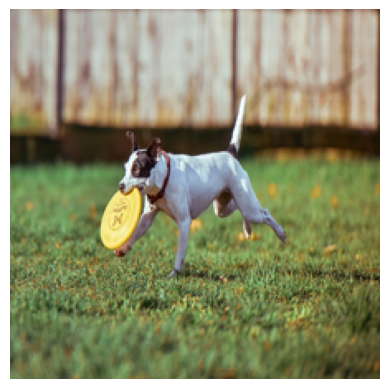

入力画像: adorable-1849992_1920.jpg
出力キャプション: <start> a dog with mouth mouth up to catch a frisbee <end>


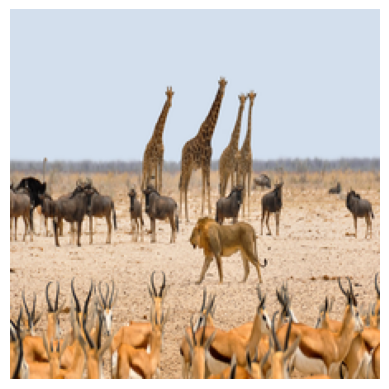

入力画像: africa-1170179_1920.jpg
出力キャプション: <start> a group of giraffes in the middle of a large


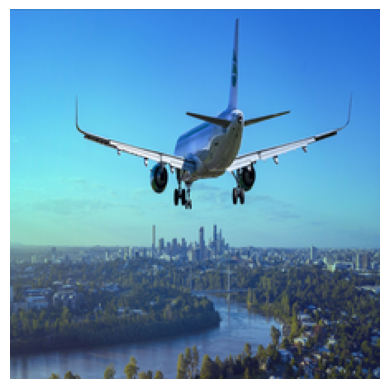

入力画像: airplane-3702676_1920.jpg
出力キャプション: <start> a view up from the wing of a plane <end>


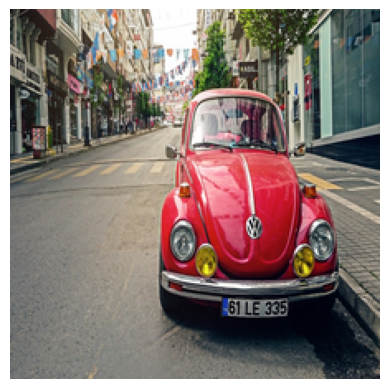

入力画像: automotive-1846910_1920.jpg
出力キャプション: <start> a car car on a street next to a <end>


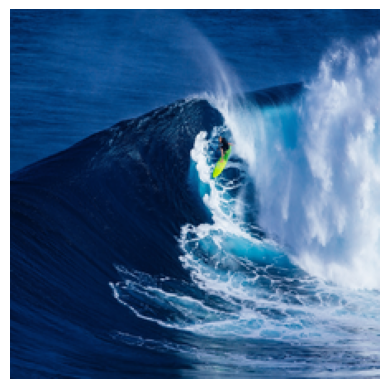

入力画像: beach-1837030_1920.jpg
出力キャプション: <start> a close up of a person surfing on a surfboard <end>


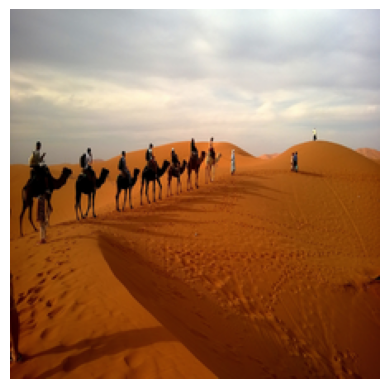

入力画像: caravan-339564_1920.jpg
出力キャプション: <start> a group of people on a bottom wearing a red in


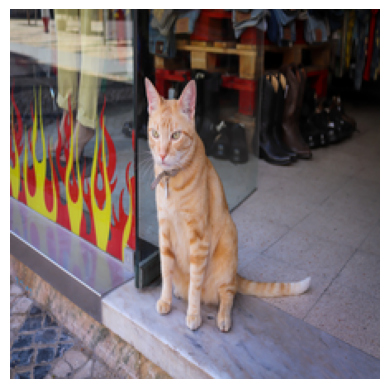

入力画像: cat-4467818_1920.jpg
出力キャプション: <start> a cat sitting on a sidewalk next to a door door


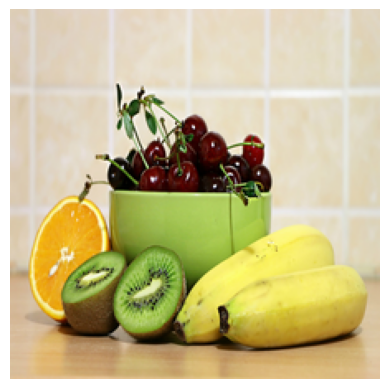

入力画像: cherry-1468933_1920.jpg
出力キャプション: <start> a bowl of fruit on a side next to a banana <end>


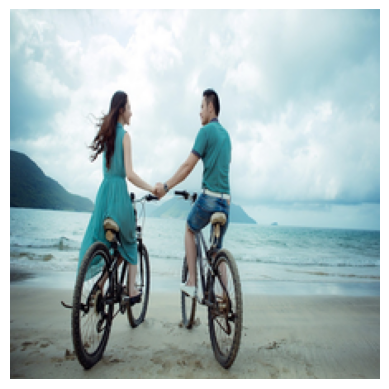

入力画像: couple-955926_1280.jpg
出力キャプション: <start> a woman riding a bike of a bicycle at the beach <end>


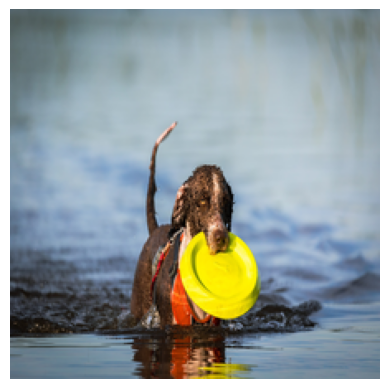

入力画像: dog-7367949_1920.jpg
出力キャプション: <start> a up up of a dog dog holding a frisbee <end>


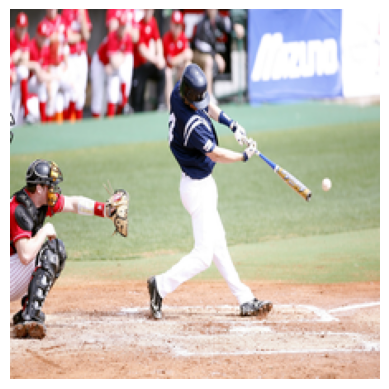

入力画像: hit-1407826_1920.jpg
出力キャプション: <start> a baseball player waiting hit a pitch during a game <end>


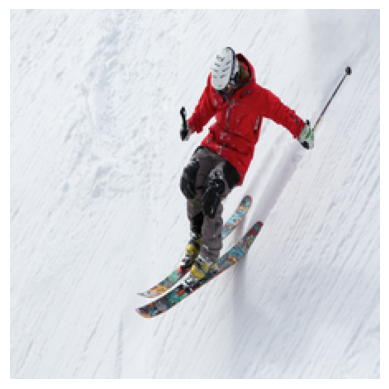

入力画像: man-498473_1920.jpg
出力キャプション: <start> a person on a snow board down a hill <end>


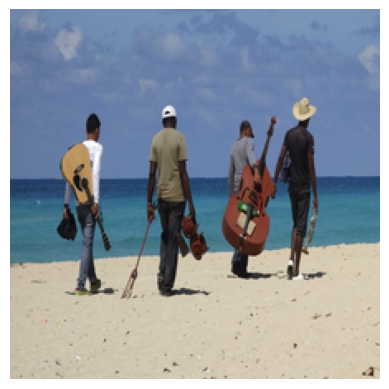

入力画像: musician-743973_1920.jpg
出力キャプション: <start> a man and a woman holding a surfboard in the ocean <end>


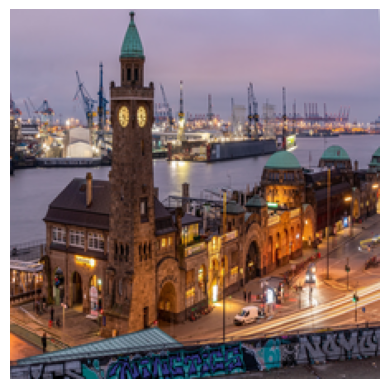

入力画像: port-5788261_1920.jpg
出力キャプション: <start> a picture of a large building with a clock on it


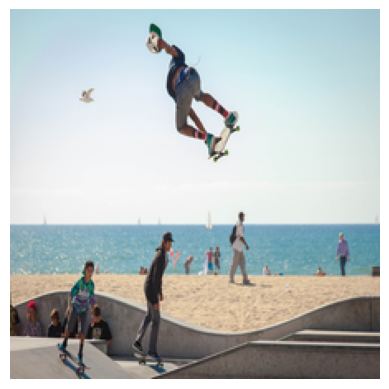

入力画像: profile-7579739_1920.jpg
出力キャプション: <start> a man on a skateboard board at a skateboard <end>


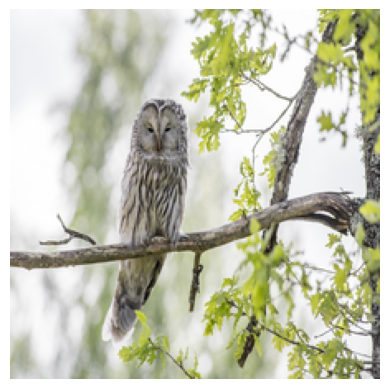

入力画像: ural-owl-4808774_1920.jpg
出力キャプション: <start> a up up of a bird on a branch branch


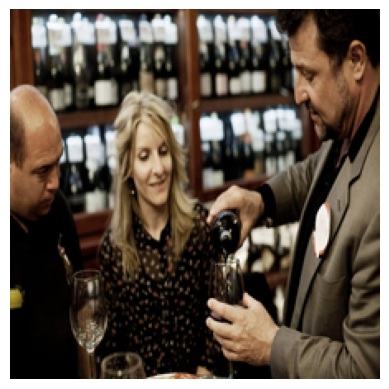

入力画像: wine-bar-2139973_1920.jpg
出力キャプション: <start> a man holding a glass face cake in a counter <end>


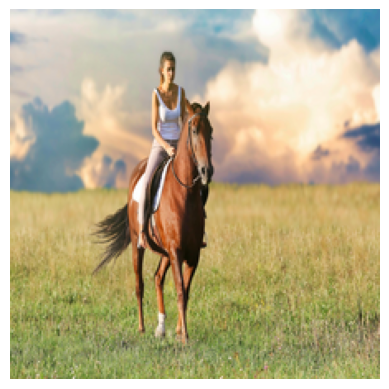

入力画像: woman-3432069_1920.jpg
出力キャプション: <start> a woman in the middle of a horse and up <end>


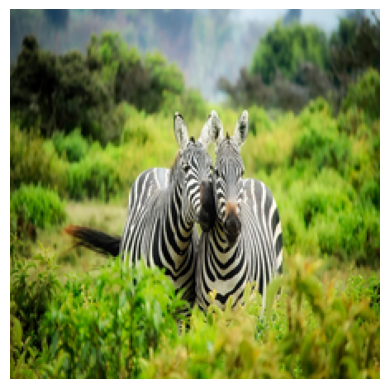

入力画像: zebras-1883654_1920.jpg
出力キャプション: <start> a close up of a zebra in a field <end>


In [46]:
demo()